# Quickstart Example of Advanced Off-Policy Evaluation and Selection (Discrete)
This notebook provides an example of conducting advanced **Off-policy Evaluation (OPE) and Off-Policy Selection OPS)** with a synthetic recommender system (REC) dataset.

This example consists of the following 3 steps: 
1. Setup, Synthetic Data Generation, and Offline Policy Learning
2. Various Off-Policy Evaluation (Policy Value Estimate, Cumulative Distribution Function Estimate)
3. Off-Policy Selection

\* This library uses [d3rlpy](https://github.com/takuseno/d3rlpy)'s algorithm implementations of offline rl policies and model-based evaluation.  
\* Also, our implementations of OPE are highly inspired by [Open Bandit Pipeline](https://github.com/st-tech/zr-obp).

In [1]:
# delete later
%load_ext autoreload
%autoreload 2

In [2]:
# delete later
import warnings
warnings.simplefilter('ignore')

In [3]:
# delete later
import sys
sys.path.append('../')
sys.path.append('../../')

In [4]:
# import OFRL modules
import ofrl
from recgym import RECEnv
from ofrl.dataset import SyntheticDataset
from ofrl.policy import OnlineHead
from ofrl.policy import DiscreteEpsilonGreedyHead as EpsilonGreedyHead
from ofrl.policy import DiscreteSoftmaxHead as SoftmaxHead
from ofrl.ope.online import (
    calc_on_policy_policy_value,
    visualize_on_policy_policy_value,
)

# import d3rlpy algorithms
from d3rlpy.algos import DiscreteRandomPolicy as RandomPolicy
# from d3rlpy.preprocessing import MinMaxScaler
from ofrl.utils import MinMaxScaler


# import from other libraries
import gym
import torch
from sklearn.model_selection import train_test_split

In [5]:
import pickle
from glob import glob
from tqdm import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [6]:
# version
print(ofrl.__version__)

0.0.0


In [7]:
# set random state
random_state = 12345

In [8]:
# log directory
from pathlib import Path
Path("logs/").mkdir(exist_ok=True)

## 1. Setup, Synthetic Data Generation, and Offline Policy Learning
To begin with, we briefly describe how the recommender environment works.

#### RL setup for recommendation
In recommendation, the objective of the RL agent is to maximize reward.

We often formulate this recommendation problem as the following (Partially Observable) Markov Decision Process ((PO)MDP):
- `state`: 
   - A vector representing user preference.  The preference changes over time in an episode by the actions presented by the RL agent.
   - When the true state is unobservable, the agent uses observation instead of state.
- `action`: Indicating which item to present to the user.
- `reward`: User engagement signal. Either binary or continuous.

For more about the environmental configuration and its customization, please refer to [examples/quickstart/rec/rec_synthetic_customize_env.ipynb](https://github.com/negocia-inc/ofrl/blob/ope/examples/quickstart/rec/rec_synthetic_customize_env.ipynb).

In [9]:
# standardized environment
env = gym.make("RECEnv-v0")

In [10]:
# for api compatibility to d3rlpy
from ofrl.utils import OldGymAPIWrapper
env_ = OldGymAPIWrapper(env)

#### Synthetic Data Generation
Next, we collect logged data with a behavior policy $\pi_0$:

$$\mathcal{D}_0 := \{ \{ s_t, a_t, s_{t+1}, r_t \}_{t=1}^T \}_{i=1}^n \sim \prod_{i=1}^n d_{s_0}(s_0) \prod_{t=1}^T \pi_0(a_t | s_t) p(s_{t+1} | s_t, a_t) p(r_t | s_t, a_t),$$

where $s_t \in \mathcal{S}$ is the state observed at timestep $t$, $a_t$ is the action chosen by the behavior policy $\pi_0$, and $r_t$ is the reward. 

`SyntheticDataset` has the following arguments:
- `env`: Recommender environment for RL defined in the previous section.
- `max_episode_steps`: Maximum number of timesteps in an episode.

For more about the data collection and visualization, please refer to [examples/quickstart/rec/rec_synthetic_data_collection.ipynb](https://github.com/negocia-inc/ofrl/blob/ope/examples/quickstart/rec/rec_synthetic_data_collection.ipynb).

In [11]:
# behavior policy
from d3rlpy.algos import DoubleDQN
from d3rlpy.models.encoders import VectorEncoderFactory
from d3rlpy.models.q_functions import MeanQFunctionFactory
from d3rlpy.online.buffers import ReplayBuffer
from d3rlpy.online.explorers import LinearDecayEpsilonGreedy

# model
ddqn = DoubleDQN(
    encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    q_func_factory=MeanQFunctionFactory(),
    target_update_interval=100,
    use_gpu=torch.cuda.is_available(),
)
# replay buffer
buffer = ReplayBuffer(
    maxlen=10000,
    env=env_,
)
# explorers
explorer = LinearDecayEpsilonGreedy(
    start_epsilon=1.0,
    end_epsilon=0.1,
    duration=1000,
)

In [ ]:
# start training
# skip if there is a pre-trained model
ddqn.fit_online(
    env_,
    buffer,
    explorer=explorer,
    eval_env=env_,
    n_steps=100000,
    n_steps_per_epoch=1000,
    update_start_step=1000,
)

In [13]:
# save model
ddqn.save_model("d3rlpy_logs/ddqn.pt")

In [12]:
# reload model
ddqn.build_with_env(env)
ddqn.load_model("d3rlpy_logs/ddqn.pt")

In [13]:
behavior_policy_01 = EpsilonGreedyHead(
    ddqn, 
    n_actions=env.action_space.n,
    epsilon=0.1,
    name="ddqn_eps_0.1",
    random_state=random_state,
)
behavior_policy_03 = EpsilonGreedyHead(
    ddqn, 
    n_actions=env.action_space.n,
    epsilon=0.3,
    name="ddqn_eps_0.3",
    random_state=random_state,
)
behavior_policy_05 = EpsilonGreedyHead(
    ddqn, 
    n_actions=env.action_space.n,
    epsilon=0.5,
    name="ddqn_eps_0.5",
    random_state=random_state,
)
behavior_policy_07 = EpsilonGreedyHead(
    ddqn, 
    n_actions=env.action_space.n,
    epsilon=0.7,
    name="ddqn_eps_0.7",
    random_state=random_state,
)
behavior_policies = [behavior_policy_01, behavior_policy_03, behavior_policy_05, behavior_policy_07]

In [14]:
# initialize dataset class
dataset = SyntheticDataset(
    env=env,
    max_episode_steps=env.step_per_episode,
)

In [16]:
# collect logged data by a behavior policy
# skip if there is a preserved logged dataset
train_logged_dataset = dataset.obtain_episodes(
    behavior_policies=behavior_policies, 
    # n_datasets=10, 
    n_datasets=2, 
    n_trajectories=10000, 
    obtain_info=False,
    random_state=random_state,
)
test_logged_dataset = dataset.obtain_episodes(
    behavior_policies=behavior_policies, 
    # n_datasets=10, 
    n_datasets=2, 
    n_trajectories=10000, 
    obtain_info=False,
    random_state=random_state + 1,
)

[obtain_datasets: behavior_policy]:   0%|          | 0/4 [00:00<?, ?it/s]

[obtain_datasets: dataset_id]:   0%|          | 0/2 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_datasets: dataset_id]:   0%|          | 0/2 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_datasets: dataset_id]:   0%|          | 0/2 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_datasets: dataset_id]:   0%|          | 0/2 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_datasets: behavior_policy]:   0%|          | 0/4 [00:00<?, ?it/s]

[obtain_datasets: dataset_id]:   0%|          | 0/2 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_datasets: dataset_id]:   0%|          | 0/2 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_datasets: dataset_id]:   0%|          | 0/2 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_datasets: dataset_id]:   0%|          | 0/2 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

In [23]:
with open("logs/train_dataset_discrete_ddqn_multi.pkl", "wb") as f:
    pickle.dump(train_logged_dataset, f)
with open("logs/test_dataset_discrete_ddqn_multi.pkl", "wb") as f:
    pickle.dump(test_logged_dataset, f)

In [24]:
with open("logs/train_dataset_discrete_ddqn_multi.pkl", "rb") as f:
    train_logged_dataset = pickle.load(f)
with open("logs/test_dataset_discrete_ddqn_multi.pkl", "rb") as f:
    test_logged_dataset = pickle.load(f)

#### Offline Policy Learning
Here, we learn several "candidate" policies to be evaluated and selected using [d3rlpy](https://github.com/takuseno/d3rlpy)'s algorithm implementation.

For more about the offline RL procedure, please refer to [examples/quickstart/rec_synthetic_discrete_basic.ipynb](https://github.com/negocia-inc/rec_reinforcement_learing/blob/ope/examples/quickstart/rec_synthetic_discrete_basic.ipynb).

In [19]:
# import modules
from ofrl.policy.opl import OffPolicyLearning
# import models from d3rlpy
from d3rlpy.algos import DiscreteCQL as CQL

In [20]:
# evaluation policies
cql_b1 = CQL(
    encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    q_func_factory=MeanQFunctionFactory(),
    use_gpu=torch.cuda.is_available(),
)
cql_b2 = CQL(
    encoder_factory=VectorEncoderFactory(hidden_units=[100]),
    q_func_factory=MeanQFunctionFactory(),
    use_gpu=torch.cuda.is_available(),
)
cql_b3 = CQL(
    encoder_factory=VectorEncoderFactory(hidden_units=[50, 10]),
    q_func_factory=MeanQFunctionFactory(),
    use_gpu=torch.cuda.is_available(),
)

algorithms = [cql_b1, cql_b2, cql_b3]
algorithms_name = ["cql_b1", "cql_b2", "cql_b3"]

In [21]:
# initialize OPL class
opl = OffPolicyLearning(
    fitting_args={
        "n_steps": 10000,
        "scorers": {},
    }
)

In [ ]:
# obtain base policies
base_policies = opl.learn_base_policy(
    logged_dataset=train_logged_dataset,
    algorithms=algorithms,
    random_state=random_state,
)

In [26]:
with open("d3rlpy_logs/multiple_discrete_base_policies.pkl", "wb") as f:
    pickle.dump(base_policies, f)

In [27]:
with open("d3rlpy_logs/multiple_discrete_base_policies.pkl", "rb") as f:
    base_policies = pickle.load(f)

In [28]:
# policy wrapper
policy_wrappers = {
    "eps_00": (
        EpsilonGreedyHead, {
            "epsilon": 0.0,
            "n_actions": env.action_space.n,
        }
    ),
    "eps_03": (
        EpsilonGreedyHead, {
            "epsilon": 0.3,
            "n_actions": env.action_space.n,
        }
    ),
    "eps_07": (
        EpsilonGreedyHead, {
            "epsilon": 0.7,
            "n_actions": env.action_space.n,
        }
    ),
    "softmax": (
        SoftmaxHead, {
            "tau": 1.0,
            "n_actions": env.action_space.n,
        }
    )
}

In [29]:
eval_policies = opl.apply_head(
    base_policies=base_policies,
    base_policies_name=algorithms_name,
    policy_wrappers=policy_wrappers,
    random_state=random_state,
)

In [30]:
[eval_policy.name for eval_policy in eval_policies[behavior_policies[0].name][0]]

['cql_b1_eps_00',
 'cql_b1_eps_03',
 'cql_b1_eps_07',
 'cql_b1_softmax',
 'cql_b2_eps_00',
 'cql_b2_eps_03',
 'cql_b2_eps_07',
 'cql_b2_softmax',
 'cql_b3_eps_00',
 'cql_b3_eps_03',
 'cql_b3_eps_07',
 'cql_b3_softmax']

## 2. Various Off-Policy Evaluation
In this section, we aim at evaluating the various performance statistics of policies in an offline manner.

### Preparation: Create OPE Input

First, we obtain input dictionary using the CreateOPEInput class.

In [31]:
# import ope modules from OFRL
from ofrl.ope import CreateOPEInput

In [32]:
# first, prepare OPE inputs
prep = CreateOPEInput(
    env=env,
    model_args={
        "fqe": {
            "encoder_factory": VectorEncoderFactory(hidden_units=[30, 30]),
            "q_func_factory": MeanQFunctionFactory(),
            "learning_rate": 1e-4,
            "use_gpu": torch.cuda.is_available(),
        }
    },
    state_scaler=MinMaxScaler(
        minimum=test_logged_dataset.get(behavior_policy_name=behavior_policies[0].name, dataset_id=0)["state"].min(axis=0),
        maximum=test_logged_dataset.get(behavior_policy_name=behavior_policies[0].name, dataset_id=0)["state"].max(axis=0),
    ),
)

In [ ]:
# takes time
input_dict = prep.obtain_whole_inputs(
    logged_dataset=test_logged_dataset,
    evaluation_policies=eval_policies,
    require_value_prediction=True,
    n_trajectories_on_policy_evaluation=100,
    random_state=random_state,
)

In [34]:
with open("logs/ope_input_dict_discrete_multiple_datasets.pkl", "wb") as f:
    pickle.dump(input_dict, f)

In [35]:
with open("logs/ope_input_dict_discrete_multiple_datasets.pkl", "rb") as f:
    input_dict = pickle.load(f)

#### Basic Estimation

The most common approach in OPE is to estimate the estimators' average policy performance, the *policy value*.

$$ V(\pi) := \mathbb{E}\left[\sum_{t=1}^T \gamma^{t-1} r_t \mid \pi \right] $$

In [36]:
# import ope modules from OFRL
from ofrl.ope import OffPolicyEvaluation as BasicOPE
from ofrl.ope import DiscreteDirectMethod as DM
from ofrl.ope import DiscreteTrajectoryWiseImportanceSampling as TIS
from ofrl.ope import DiscretePerDecisionImportanceSampling as PDIS
from ofrl.ope import DiscreteDoublyRobust as DR
from ofrl.ope import DiscreteSelfNormalizedTrajectoryWiseImportanceSampling as SNTIS
from ofrl.ope import DiscreteSelfNormalizedPerDecisionImportanceSampling as SNPDIS
from ofrl.ope import DiscreteSelfNormalizedDoublyRobust as SNDR

In [37]:
ope = BasicOPE(
    logged_dataset=test_logged_dataset,
    ope_estimators=[DM(), TIS(), PDIS(), DR(), SNTIS(), SNPDIS(), SNDR()],
)

In [38]:
# policy value estimation by ope
policy_value_df_dict, policy_value_interval_df_dict = ope.summarize_off_policy_estimates(input_dict, random_state=random_state)
# dictionary of the estimation
policy_value_df_dict["ddqn_eps_0.3"][0]

{'cql_b1_eps_00':            policy_value  relative_policy_value
 on_policy      4.818452               1.000000
 dm             1.694606               0.351691
 tis            5.630150               1.168456
 pdis           4.830744               1.002551
 dr             4.785564               0.993174
 sntis          5.340336               1.108309
 snpdis         4.909356               1.018866
 sndr           4.956711               1.028694,
 'cql_b1_eps_03':            policy_value  relative_policy_value
 on_policy      3.105679               1.000000
 dm             1.711050               0.550942
 tis            2.847865               0.916986
 pdis           3.028404               0.975118
 dr             2.969934               0.956291
 sntis          2.535146               0.816294
 snpdis         2.832460               0.912026
 sndr           2.970998               0.956634,
 'cql_b1_eps_07':            policy_value  relative_policy_value
 on_policy      0.752302           

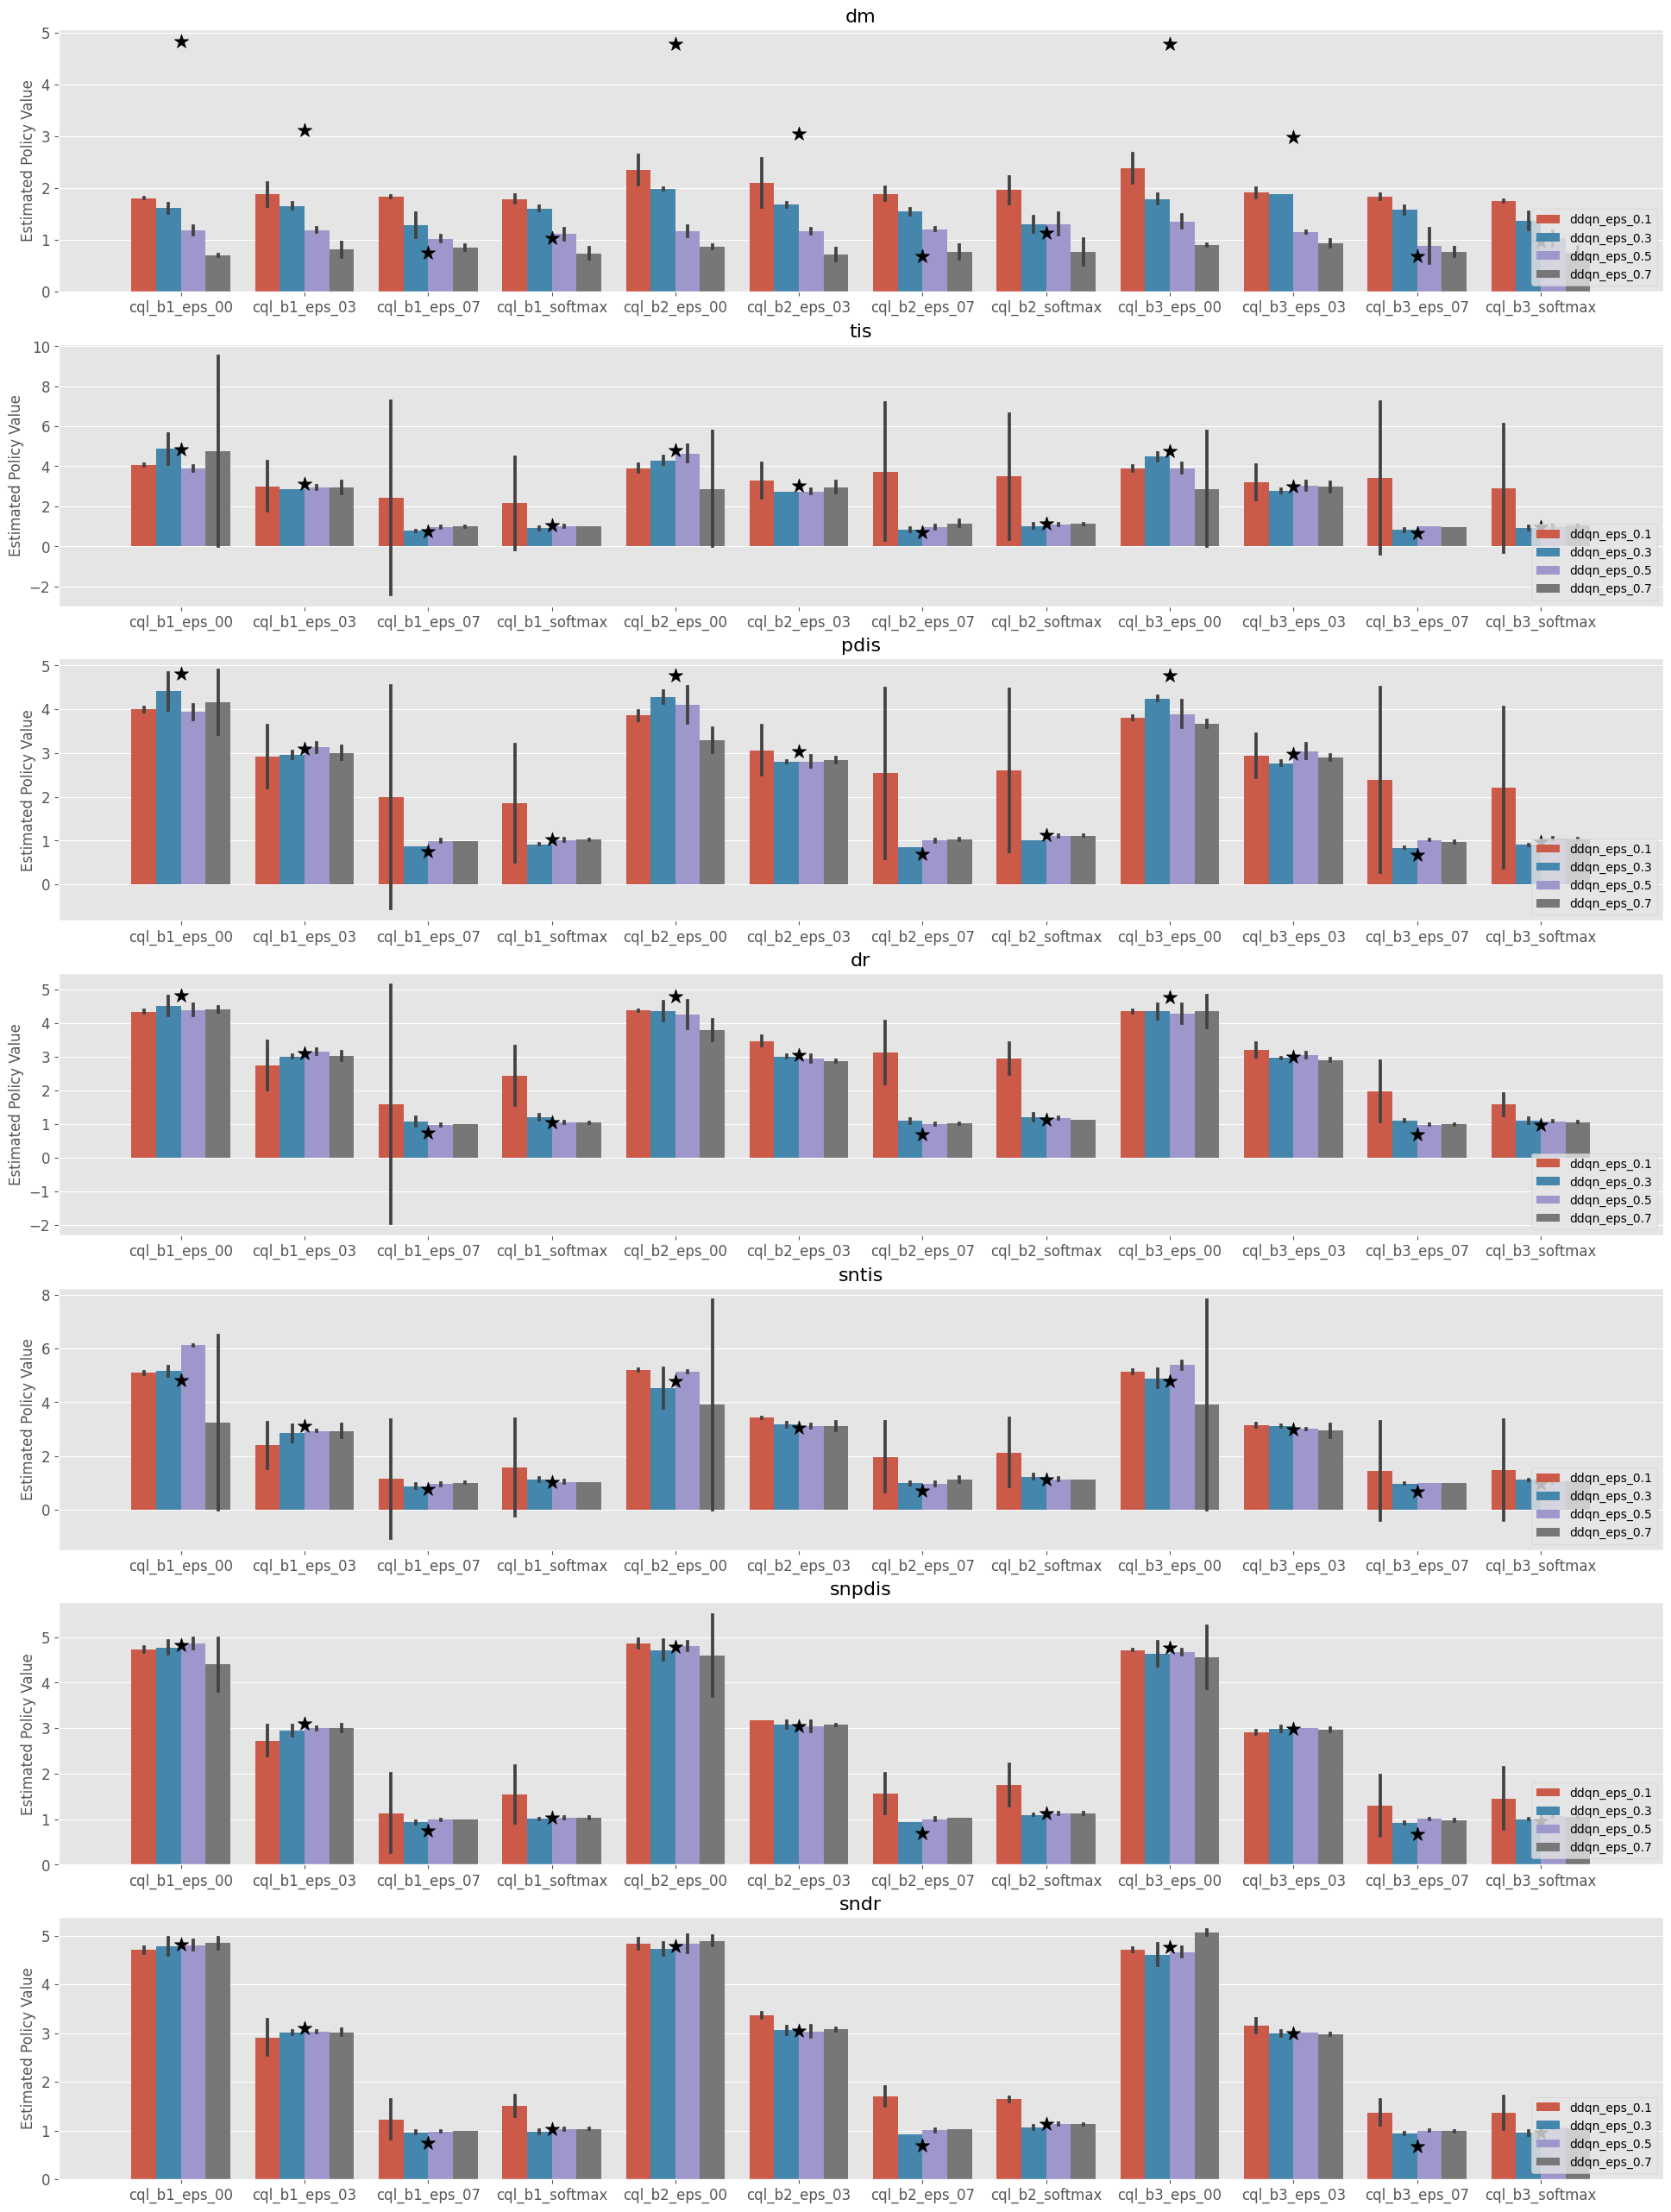

In [39]:
ope.visualize_policy_value_with_multiple_estimates(
    input_dict=input_dict,
    plot_type="ci",
    hue="policy",
)

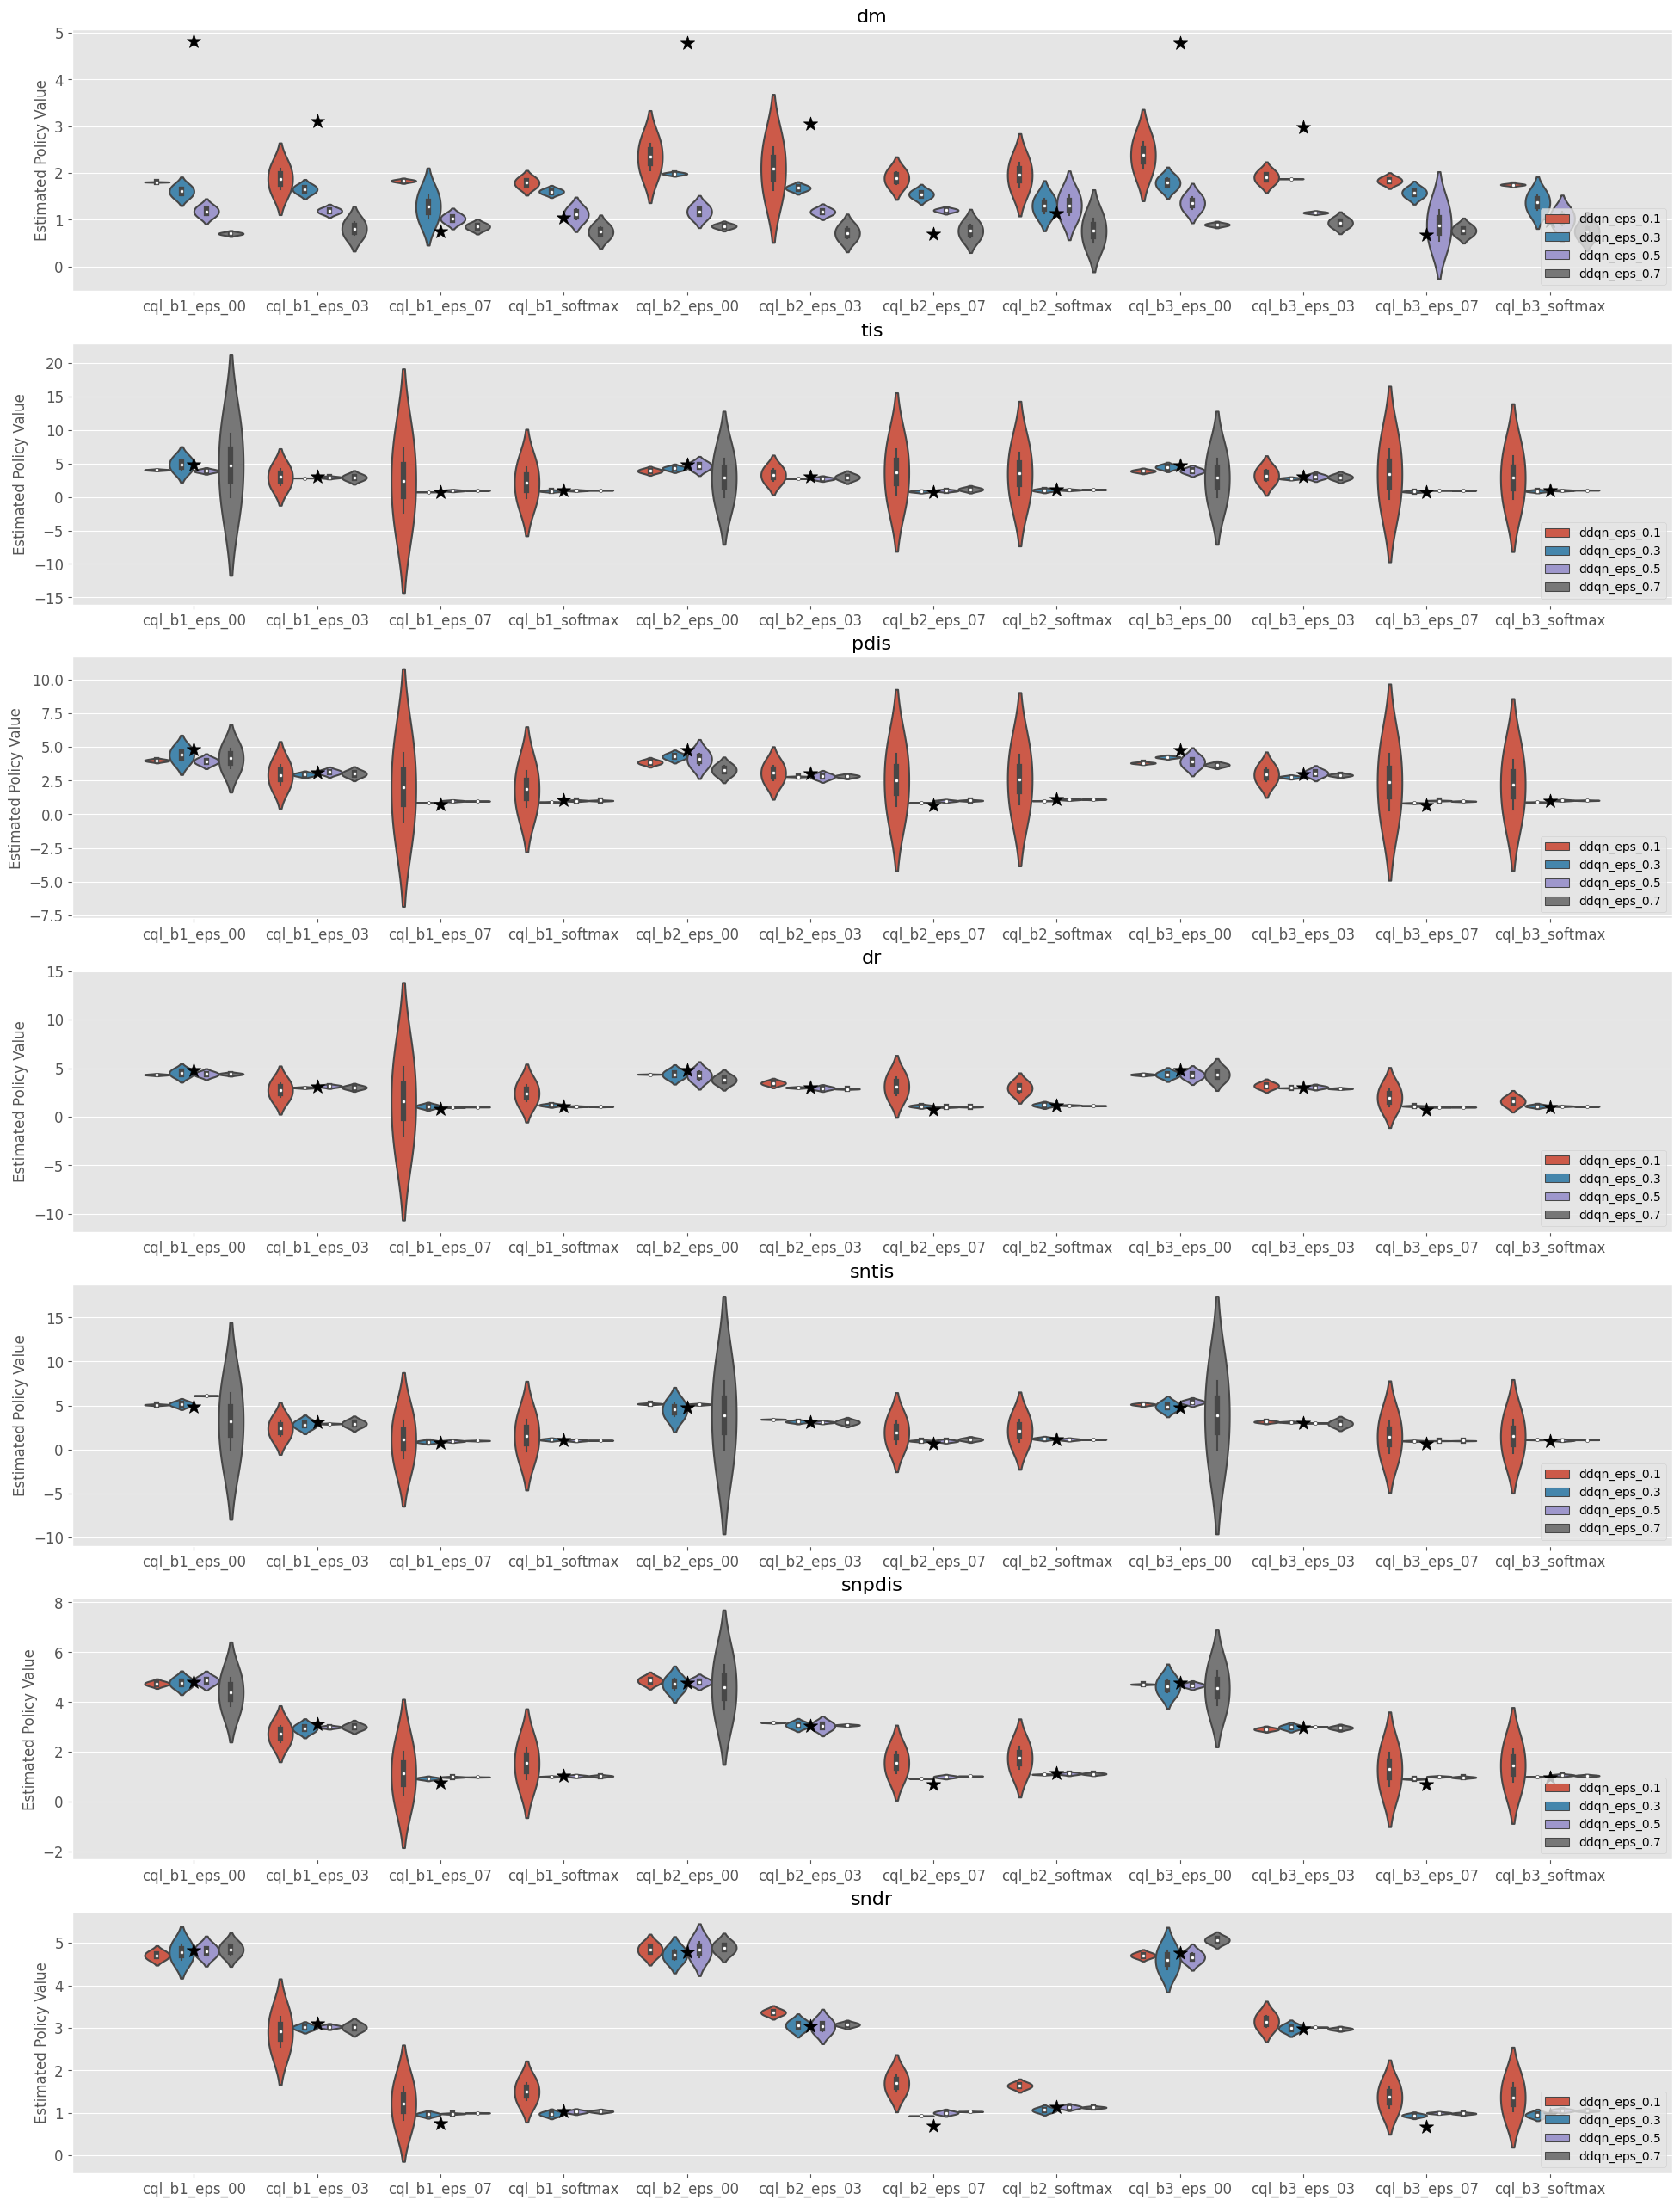

In [40]:
ope.visualize_policy_value_with_multiple_estimates(
    input_dict=input_dict,
    plot_type="violin",
    hue="policy",
)

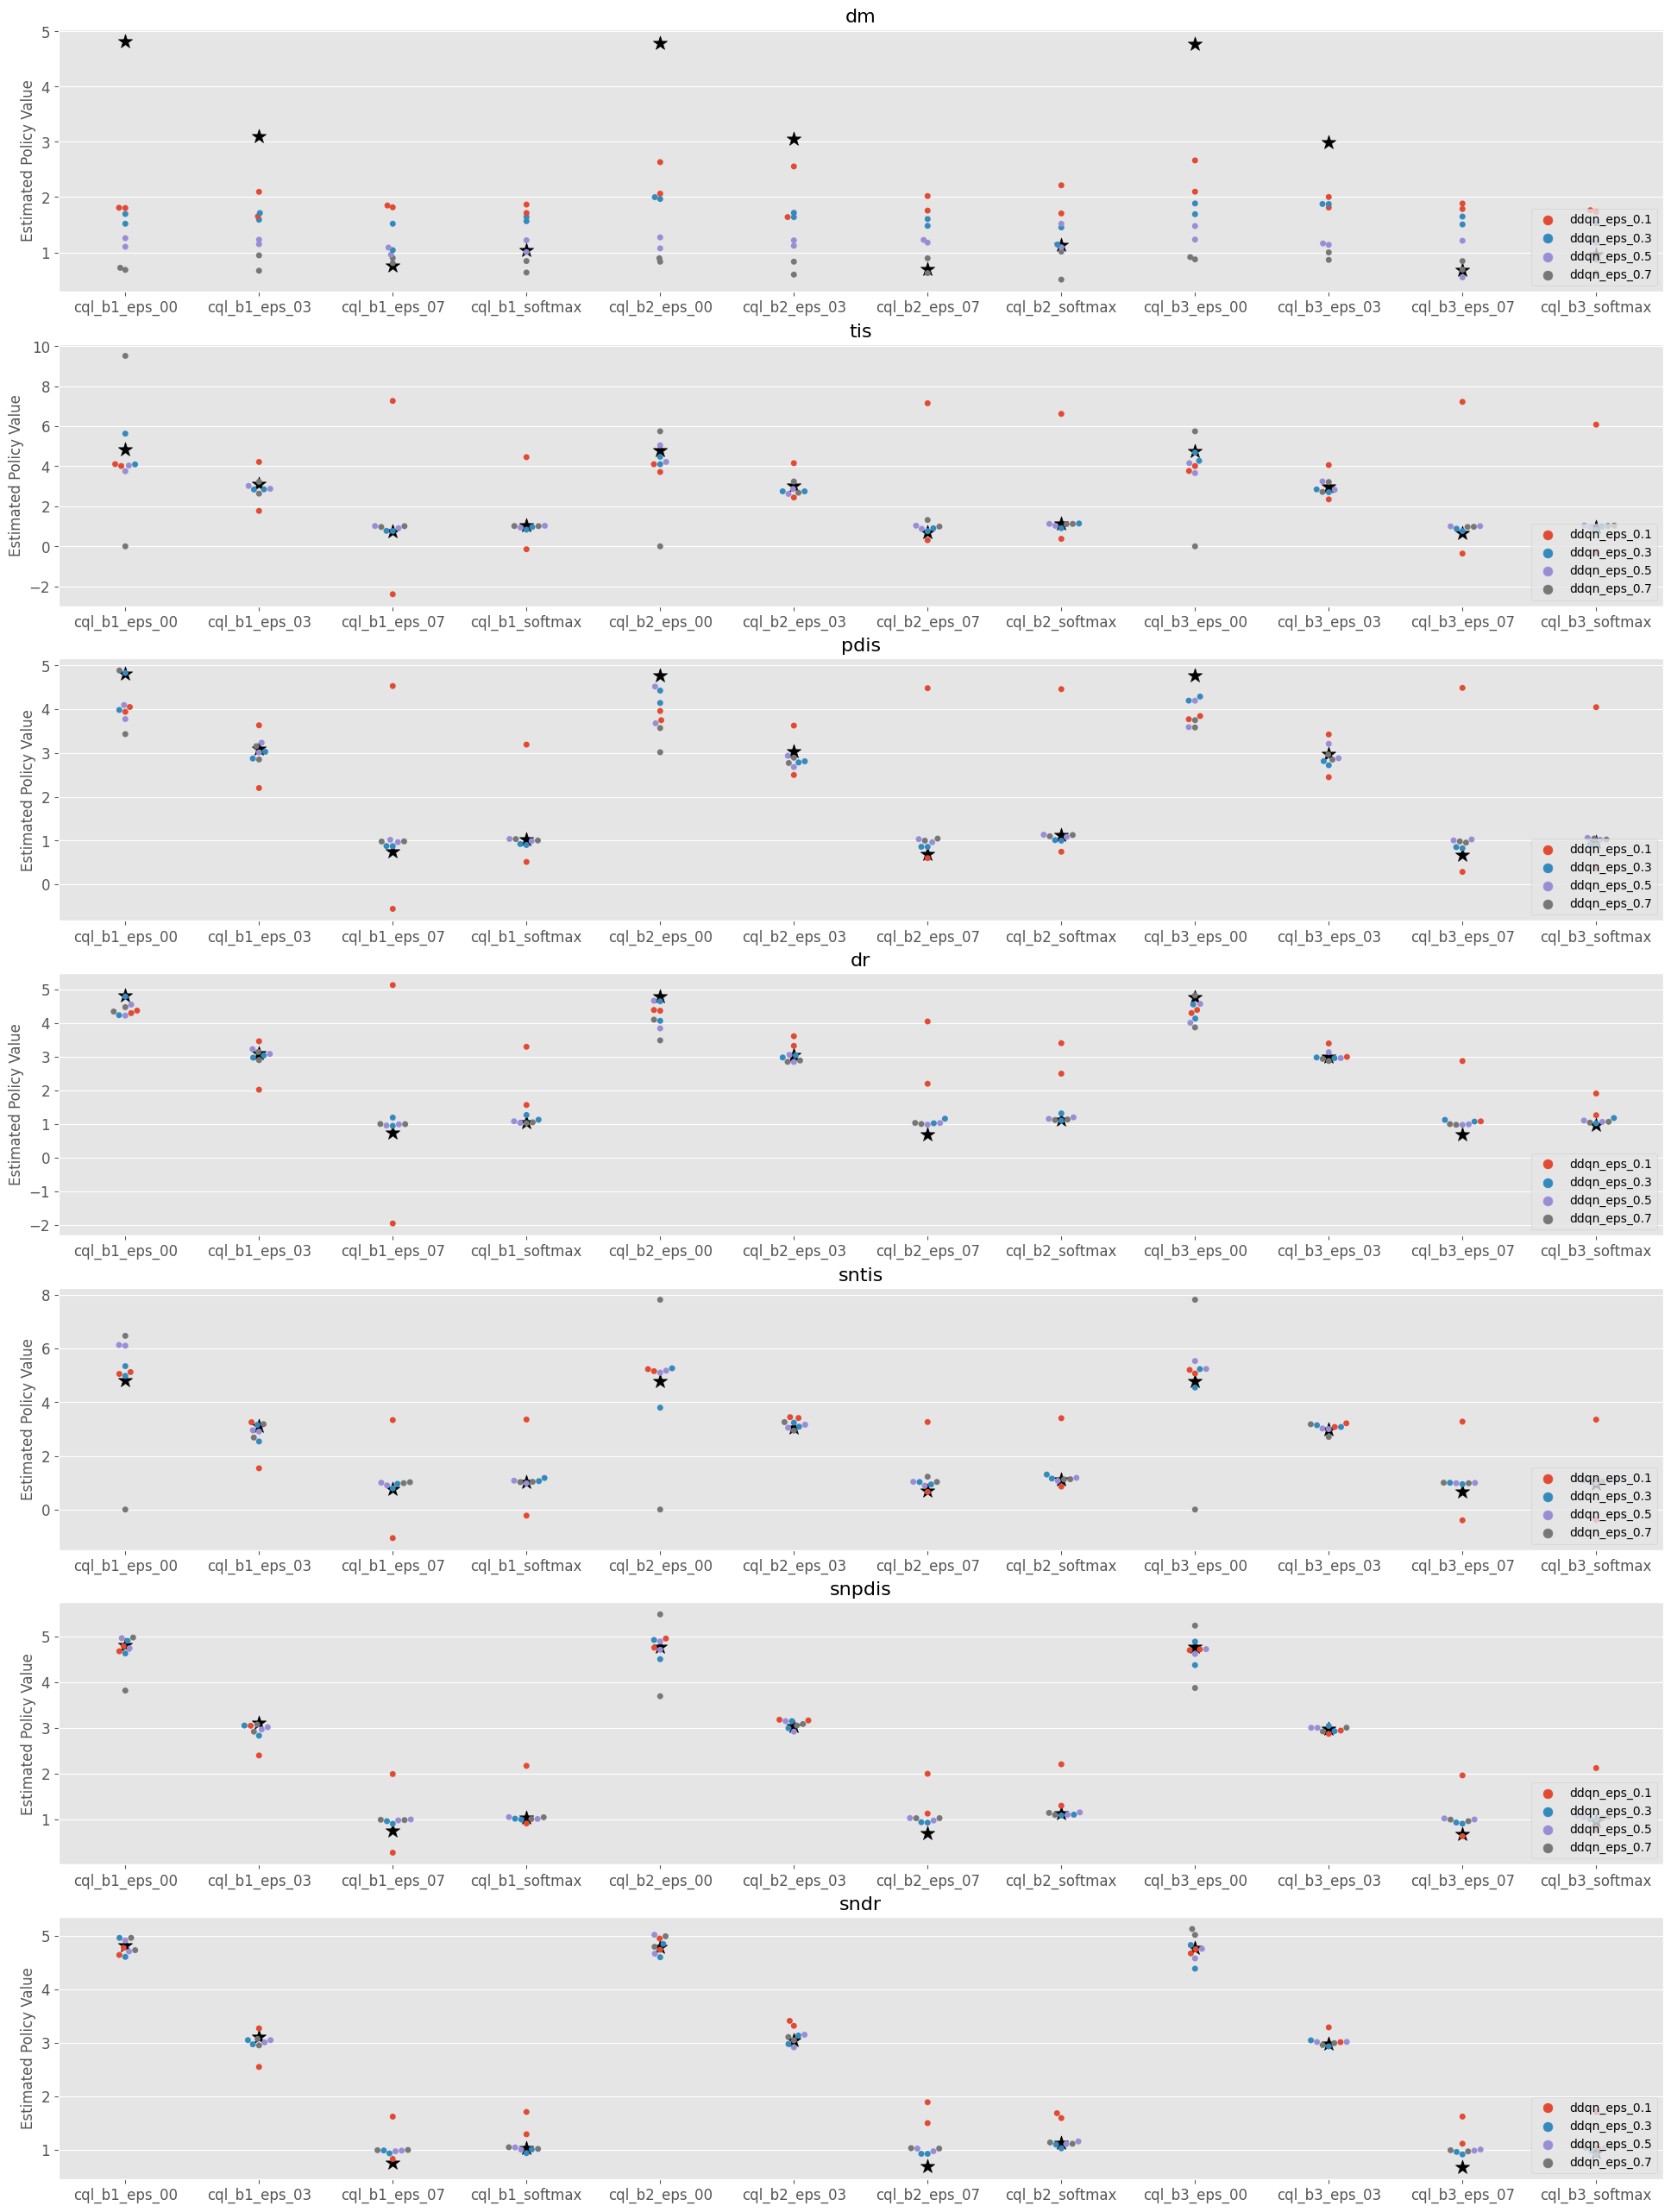

In [41]:
ope.visualize_policy_value_with_multiple_estimates(
    input_dict=input_dict,
    plot_type="scatter",
    hue="policy",
)

#### Cumulative Distribution Function Estimation
We can also estimate various statistics regarding the policy performance based on the cumulative distribution function of the trajectory wise reward.

$$ F(t, \pi) := \mathbb{E}\left[ \mathbb{I} \left \{ \sum_{t=1}^T \gamma^{t-1} r_t \leq t \right \} \mid \pi \right] $$

Specifically, we can estimate the following performance metrics.
- Cumulative Distribution Function
- Mean of the return (i.e., policy value)
- Variance of the return
- Conditional Value at Risk
- Interquartile Range

In [42]:
from ofrl.ope import CumulativeDistributionOffPolicyEvaluation as CumulativeDistributionOPE
from ofrl.ope import DiscreteCumulativeDistributionDirectMethod as CD_DM
from ofrl.ope import DiscreteCumulativeDistributionTrajectoryWiseImportanceSampling as CD_IS
from ofrl.ope import DiscreteCumulativeDistributionTrajectoryWiseDoublyRobust as CD_DR
from ofrl.ope import DiscreteCumulativeDistributionSelfNormalizedTrajectoryWiseImportanceSampling as CD_SNIS
from ofrl.ope import DiscreteCumulativeDistributionSelfNormalizedTrajectoryWiseDoublyRobust as CD_SNDR

In [43]:
cd_ope = CumulativeDistributionOPE(
    logged_dataset=test_logged_dataset,
    ope_estimators=[
        CD_DM(estimator_name="cdf_dm"), 
        CD_IS(estimator_name="cdf_is"), 
        CD_DR(estimator_name="cdf_dr"), 
        CD_SNIS(estimator_name="cdf_snis"), 
        CD_SNDR(estimator_name="cdf_sndr"),
    ],
)

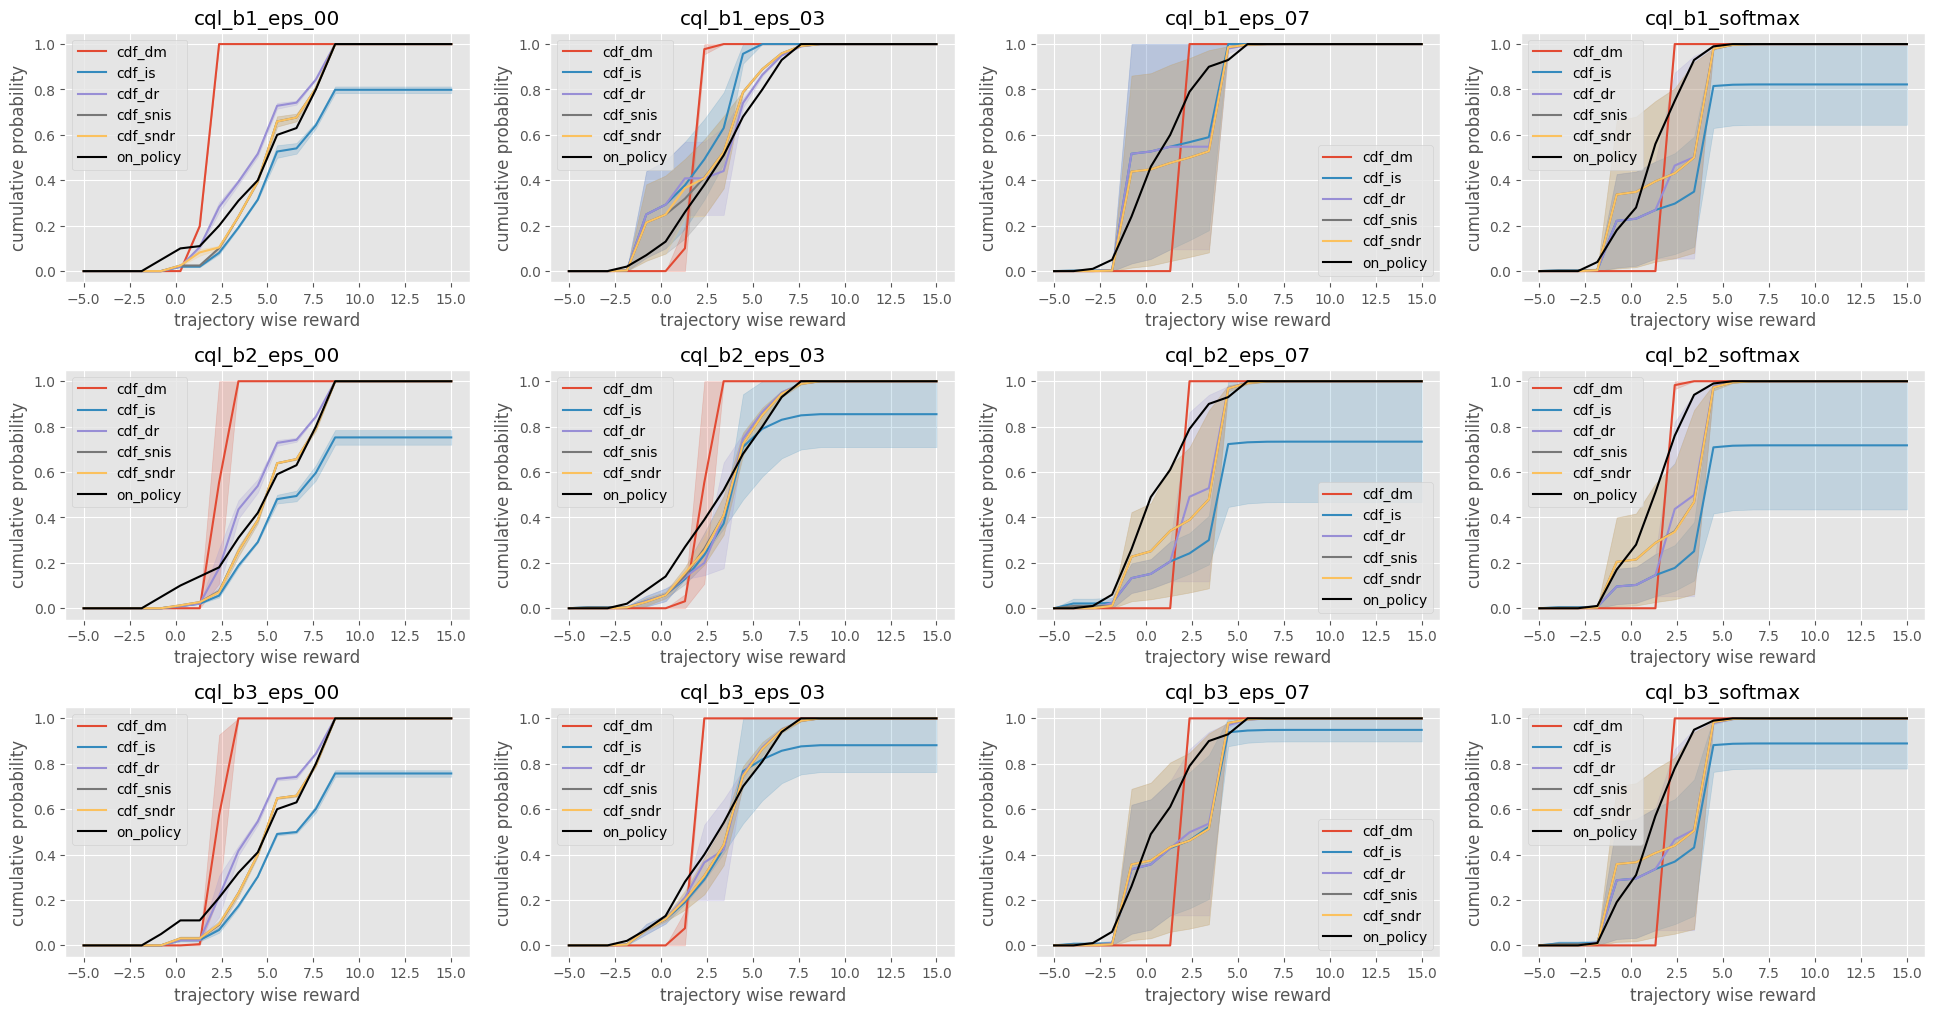

In [65]:
# cumulative distribution function
cd_ope.visualize_cumulative_distribution_function_with_multiple_estimates(
    input_dict, 
    behavior_policy_name="ddqn_eps_0.1",
    plot_type="ci_hue",
    scale_min=-5.0, 
    scale_max=15.0, 
    n_partition=20, 
    n_cols=4,
)

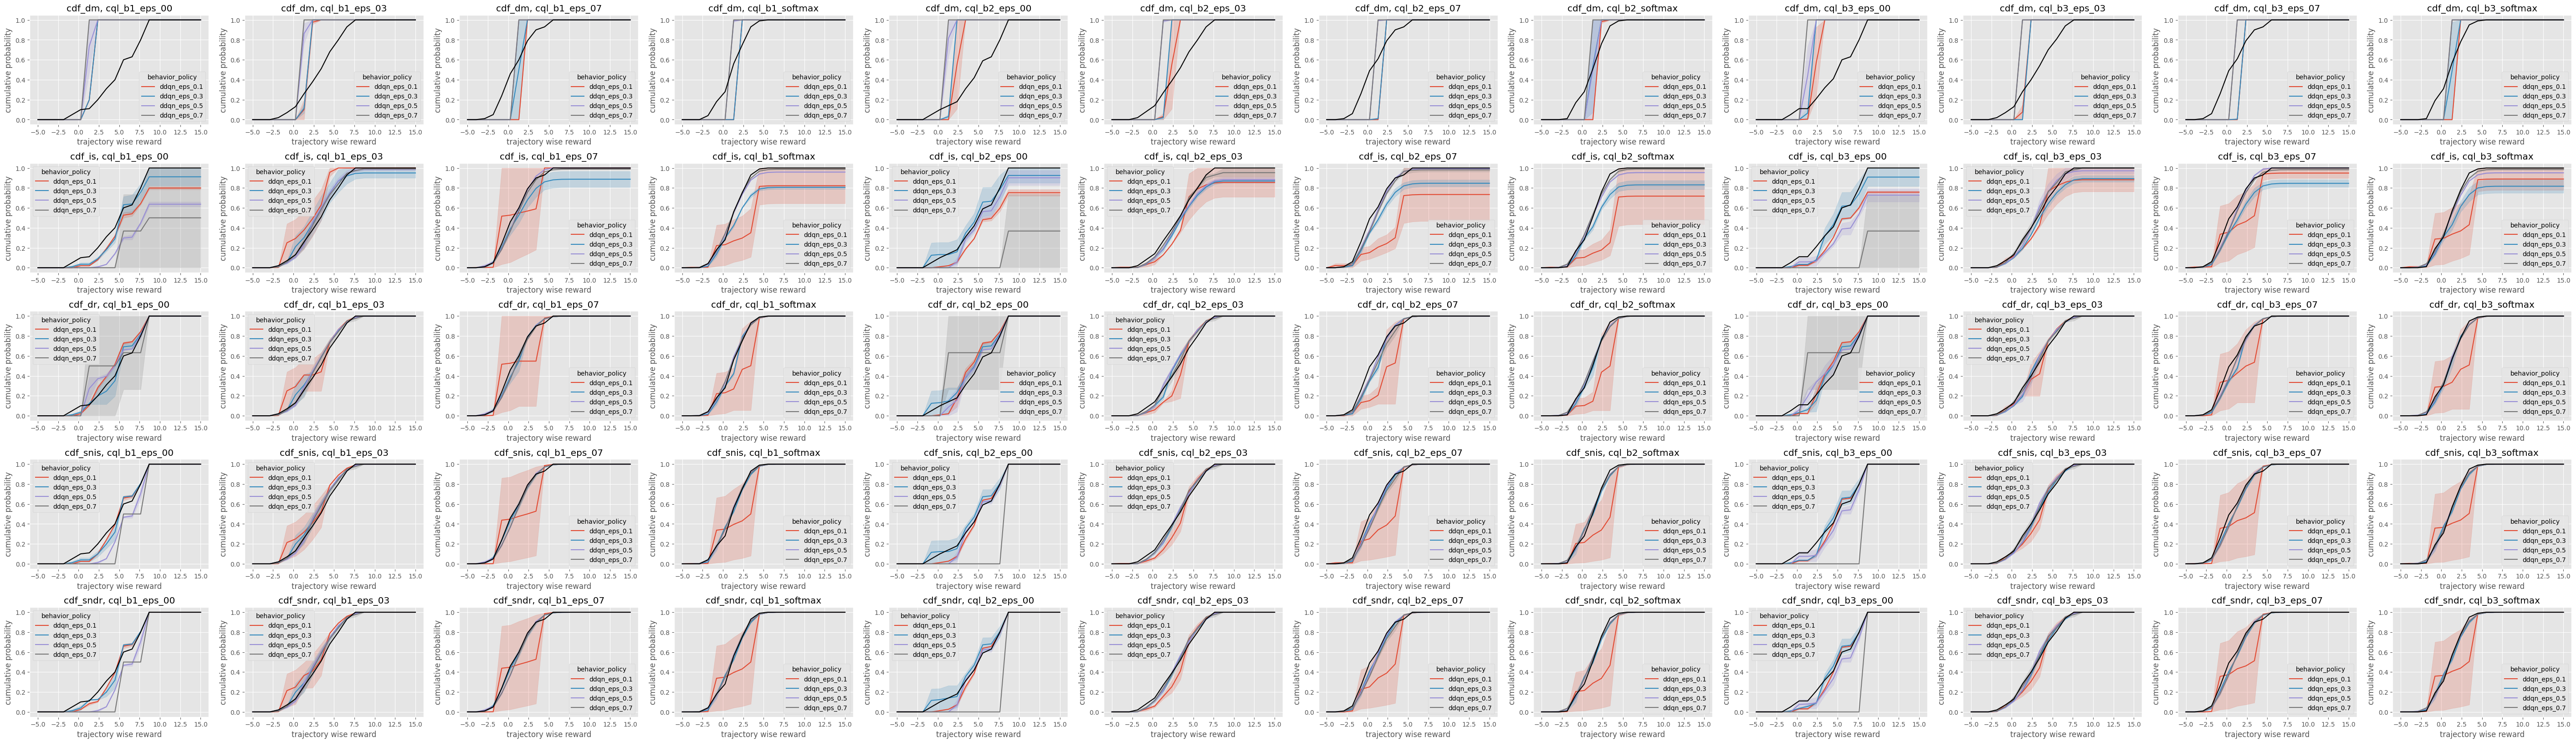

In [66]:
# cumulative distribution function
cd_ope.visualize_cumulative_distribution_function_with_multiple_estimates(
    input_dict,
    plot_type="ci_behavior_policy",
    hue="policy",
    scale_min=-5.0, 
    scale_max=15.0, 
    n_partition=20, 
)

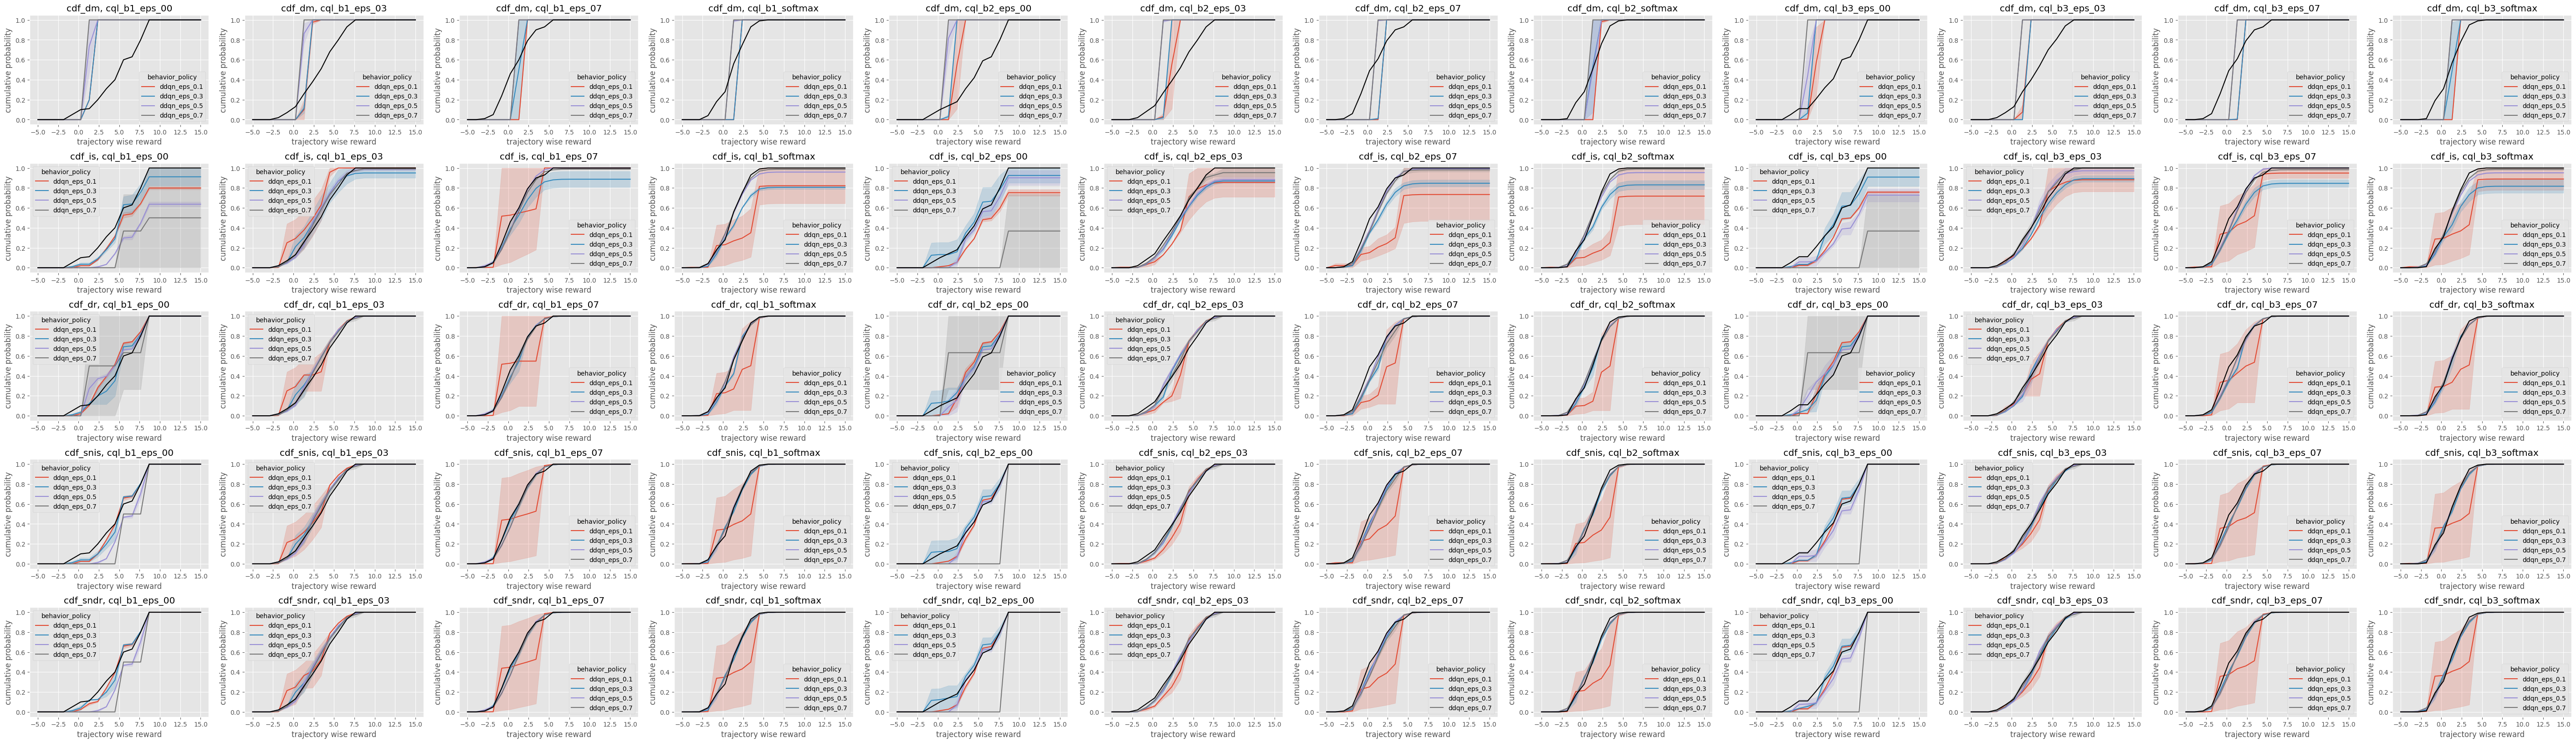

In [67]:
# cumulative distribution function
cd_ope.visualize_cumulative_distribution_function_with_multiple_estimates(
    input_dict,
    plot_type="ci_behavior_policy",
    hue="policy",
    scale_min=-5.0, 
    scale_max=15.0, 
    n_partition=20, 
)

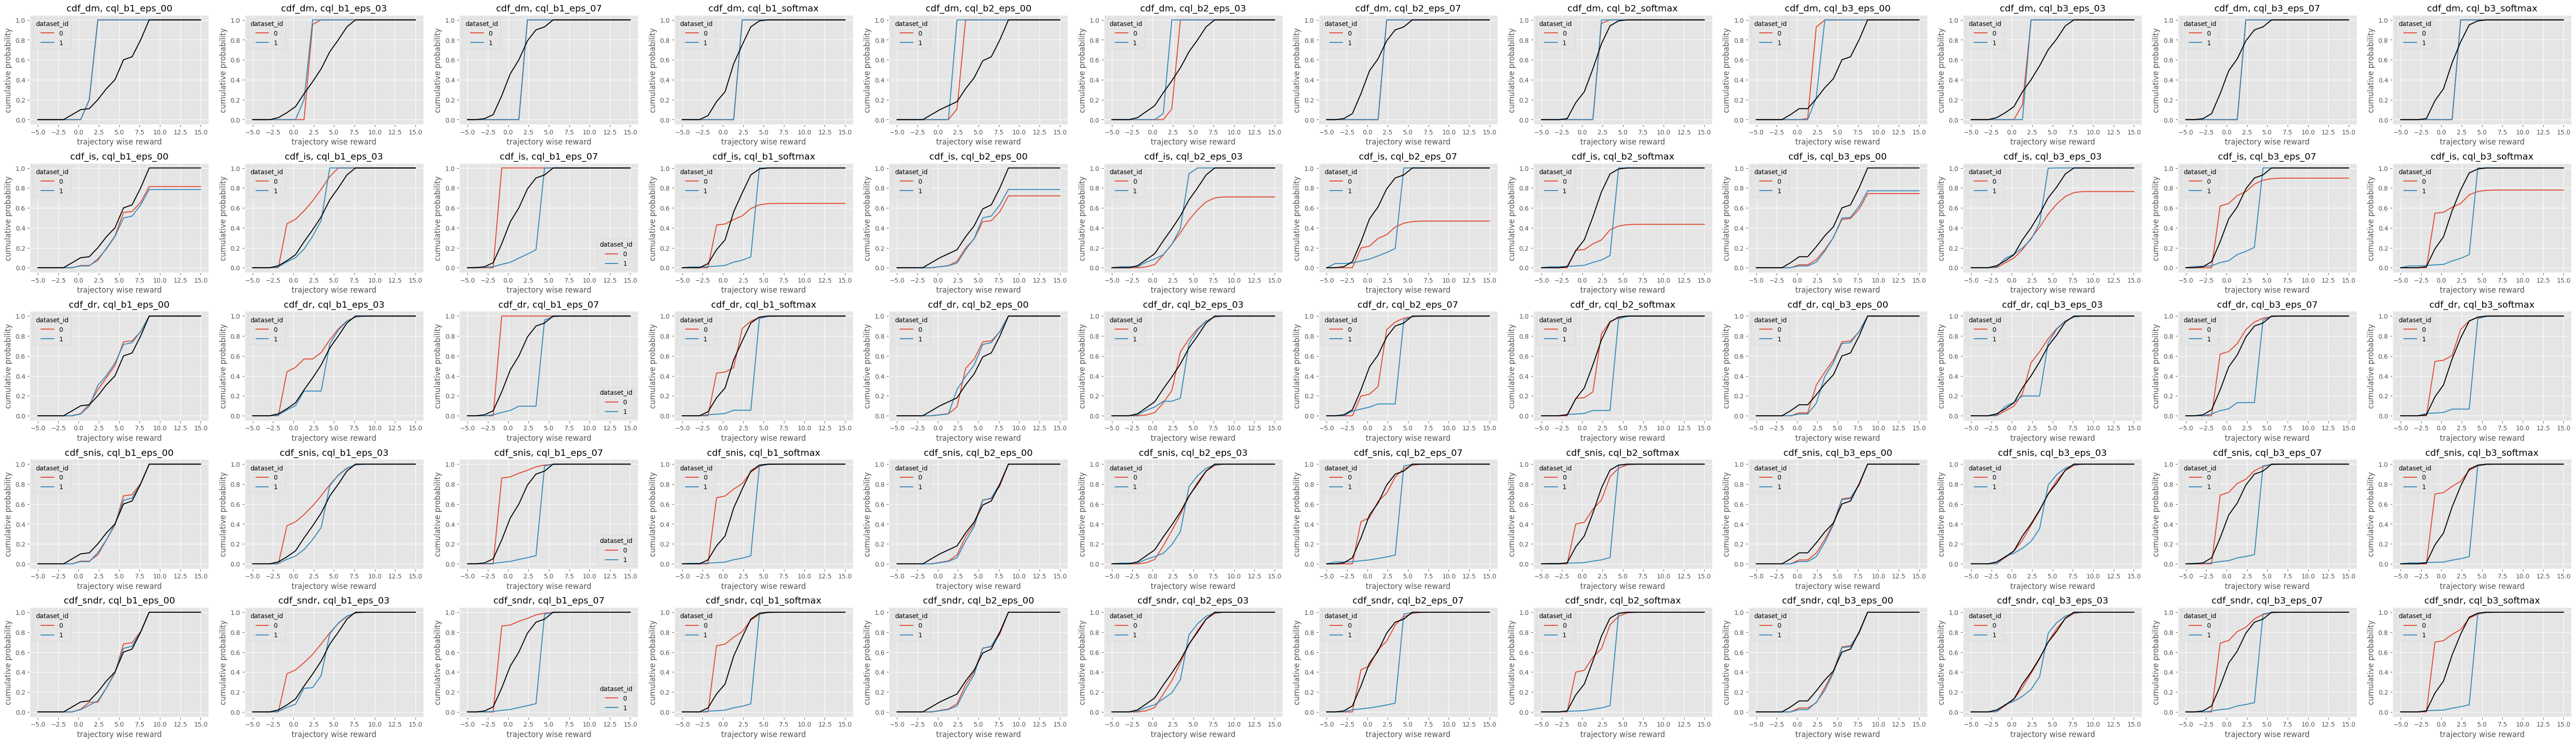

In [68]:
# cumulative distribution function
cd_ope.visualize_cumulative_distribution_function_with_multiple_estimates(
    input_dict, 
    behavior_policy_name="ddqn_eps_0.1",
    plot_type="enumerate",
    hue="policy",
    scale_min=-5.0, 
    scale_max=15.0, 
    n_partition=20, 
)

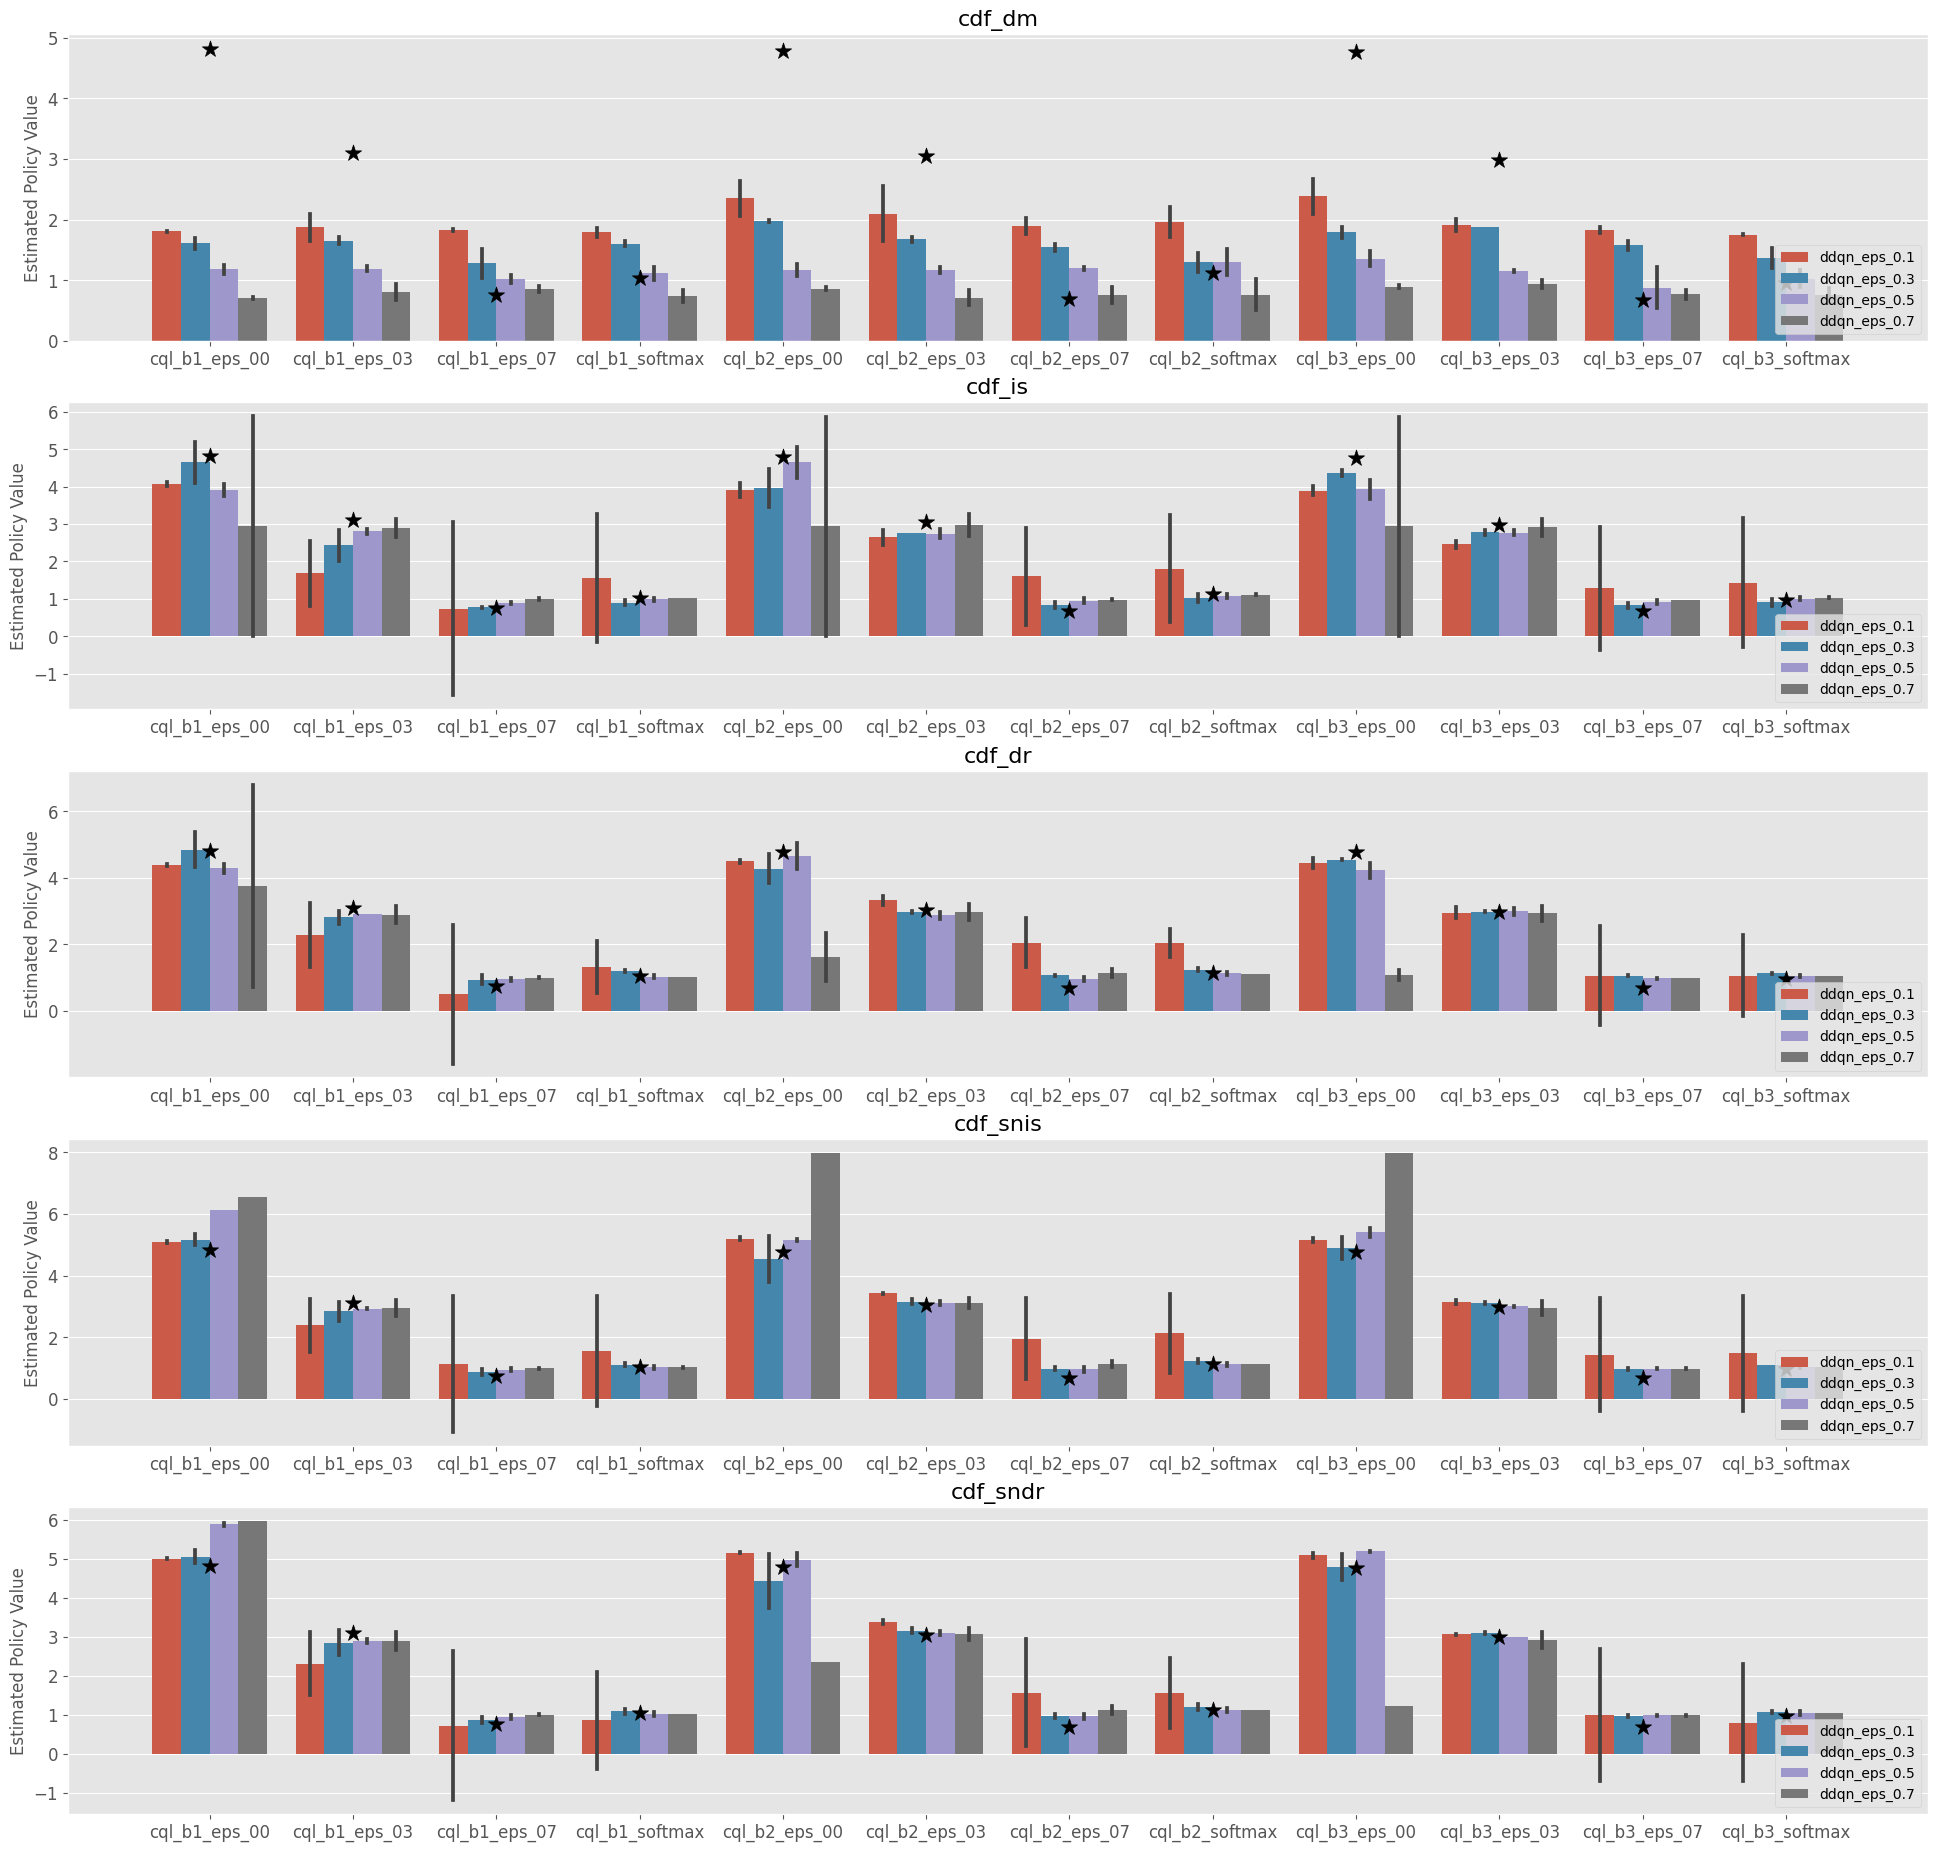

In [48]:
cd_ope.visualize_policy_value_with_multiple_estimates(
    input_dict=input_dict,
    plot_type="ci",
    hue="policy",
)

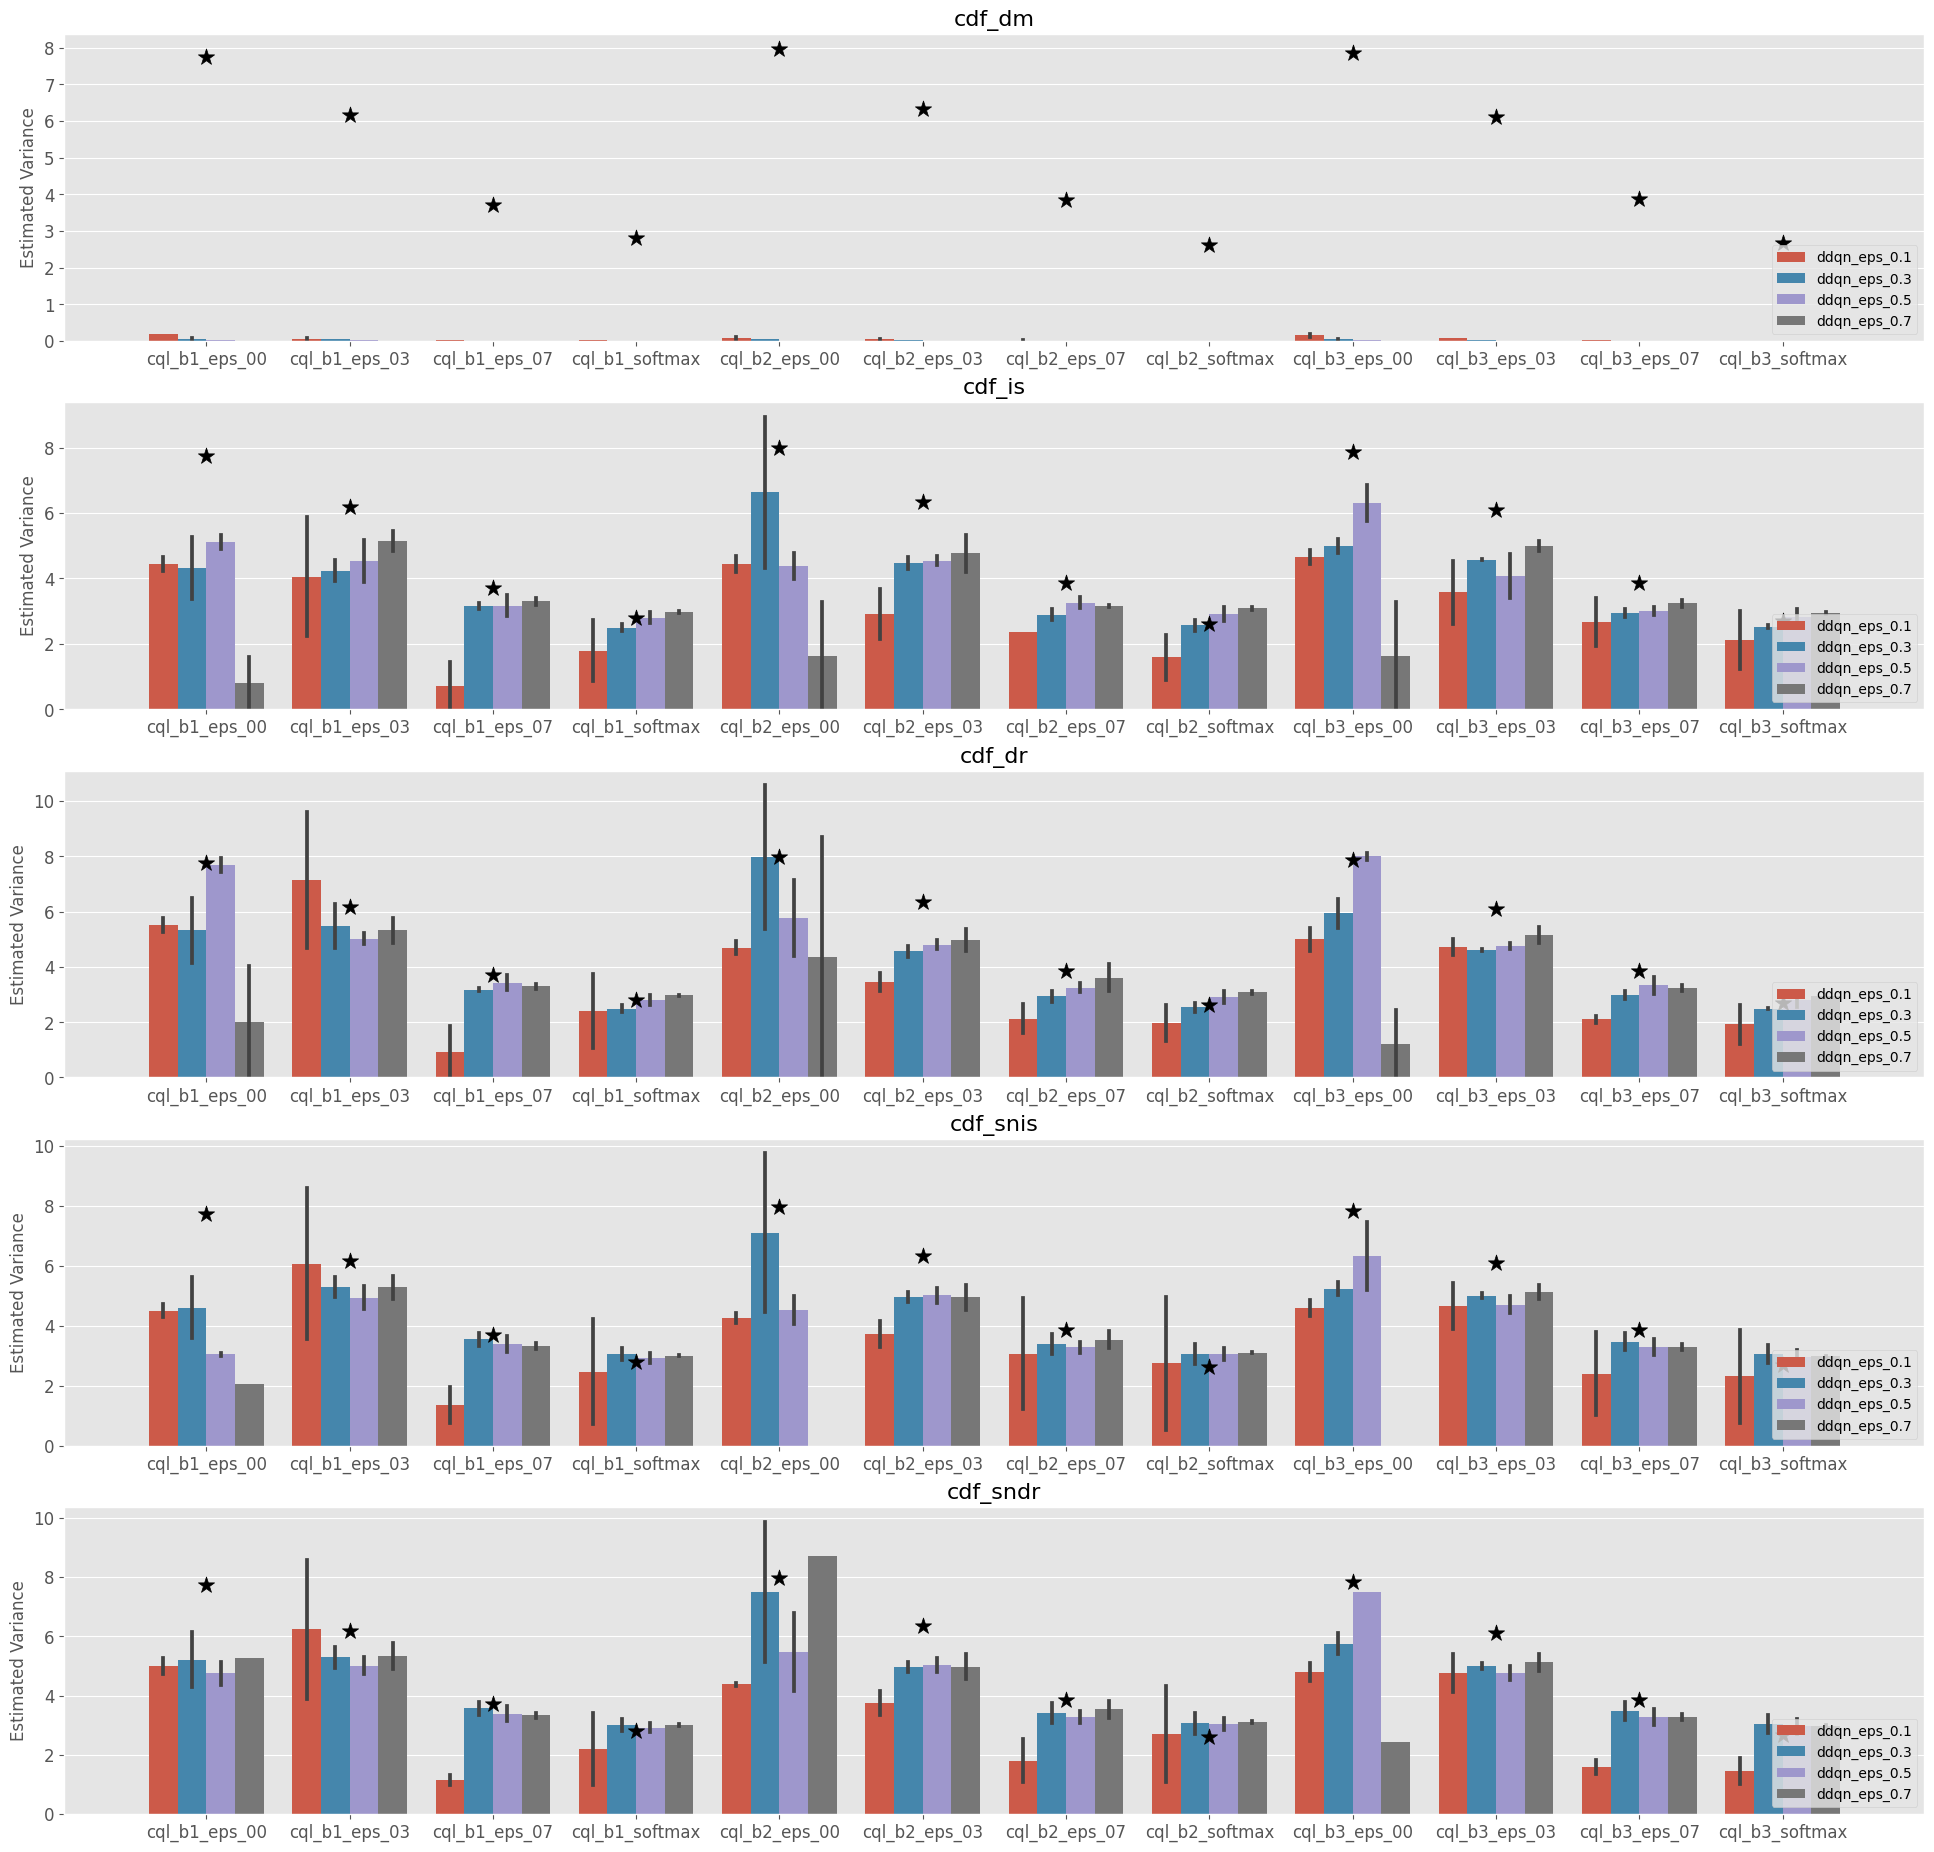

In [49]:
cd_ope.visualize_variance_with_multiple_estimates(
    input_dict=input_dict,
    plot_type="ci",
    hue="policy",
)

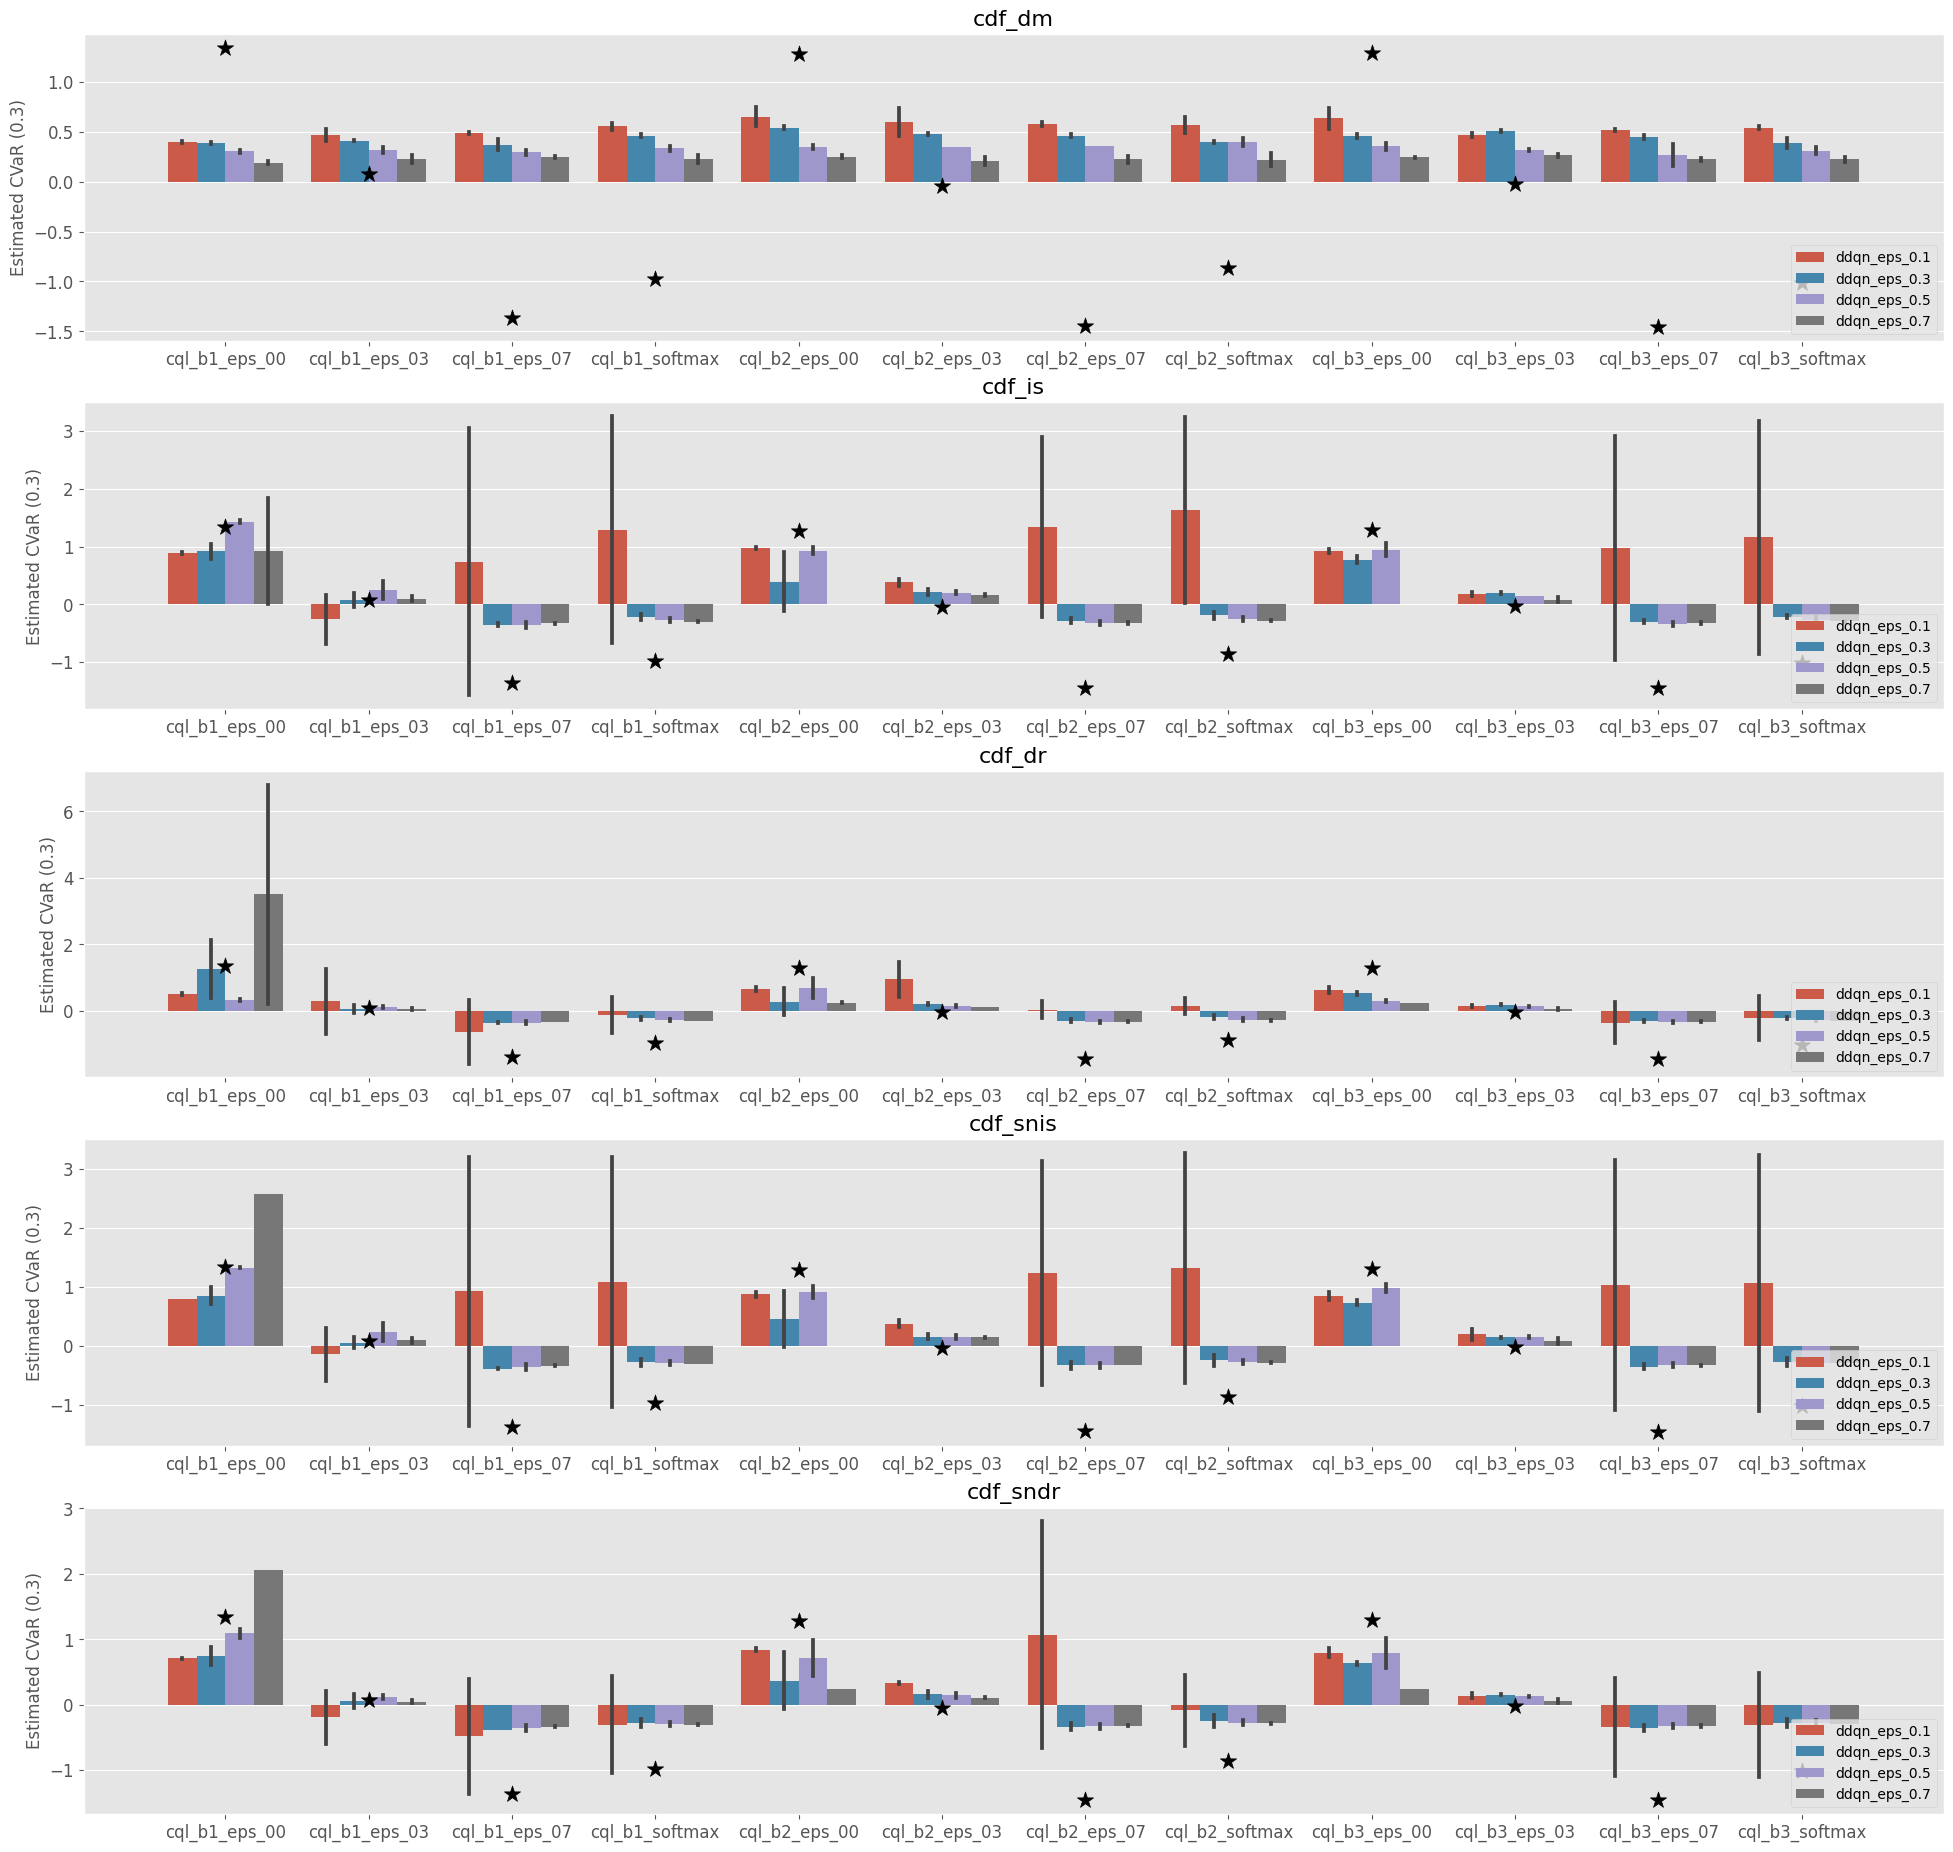

In [50]:
cd_ope.visualize_conditional_value_at_risk_with_multiple_estimates(
    input_dict=input_dict,
    alpha=0.3,
    plot_type="ci",
    hue="policy",
)

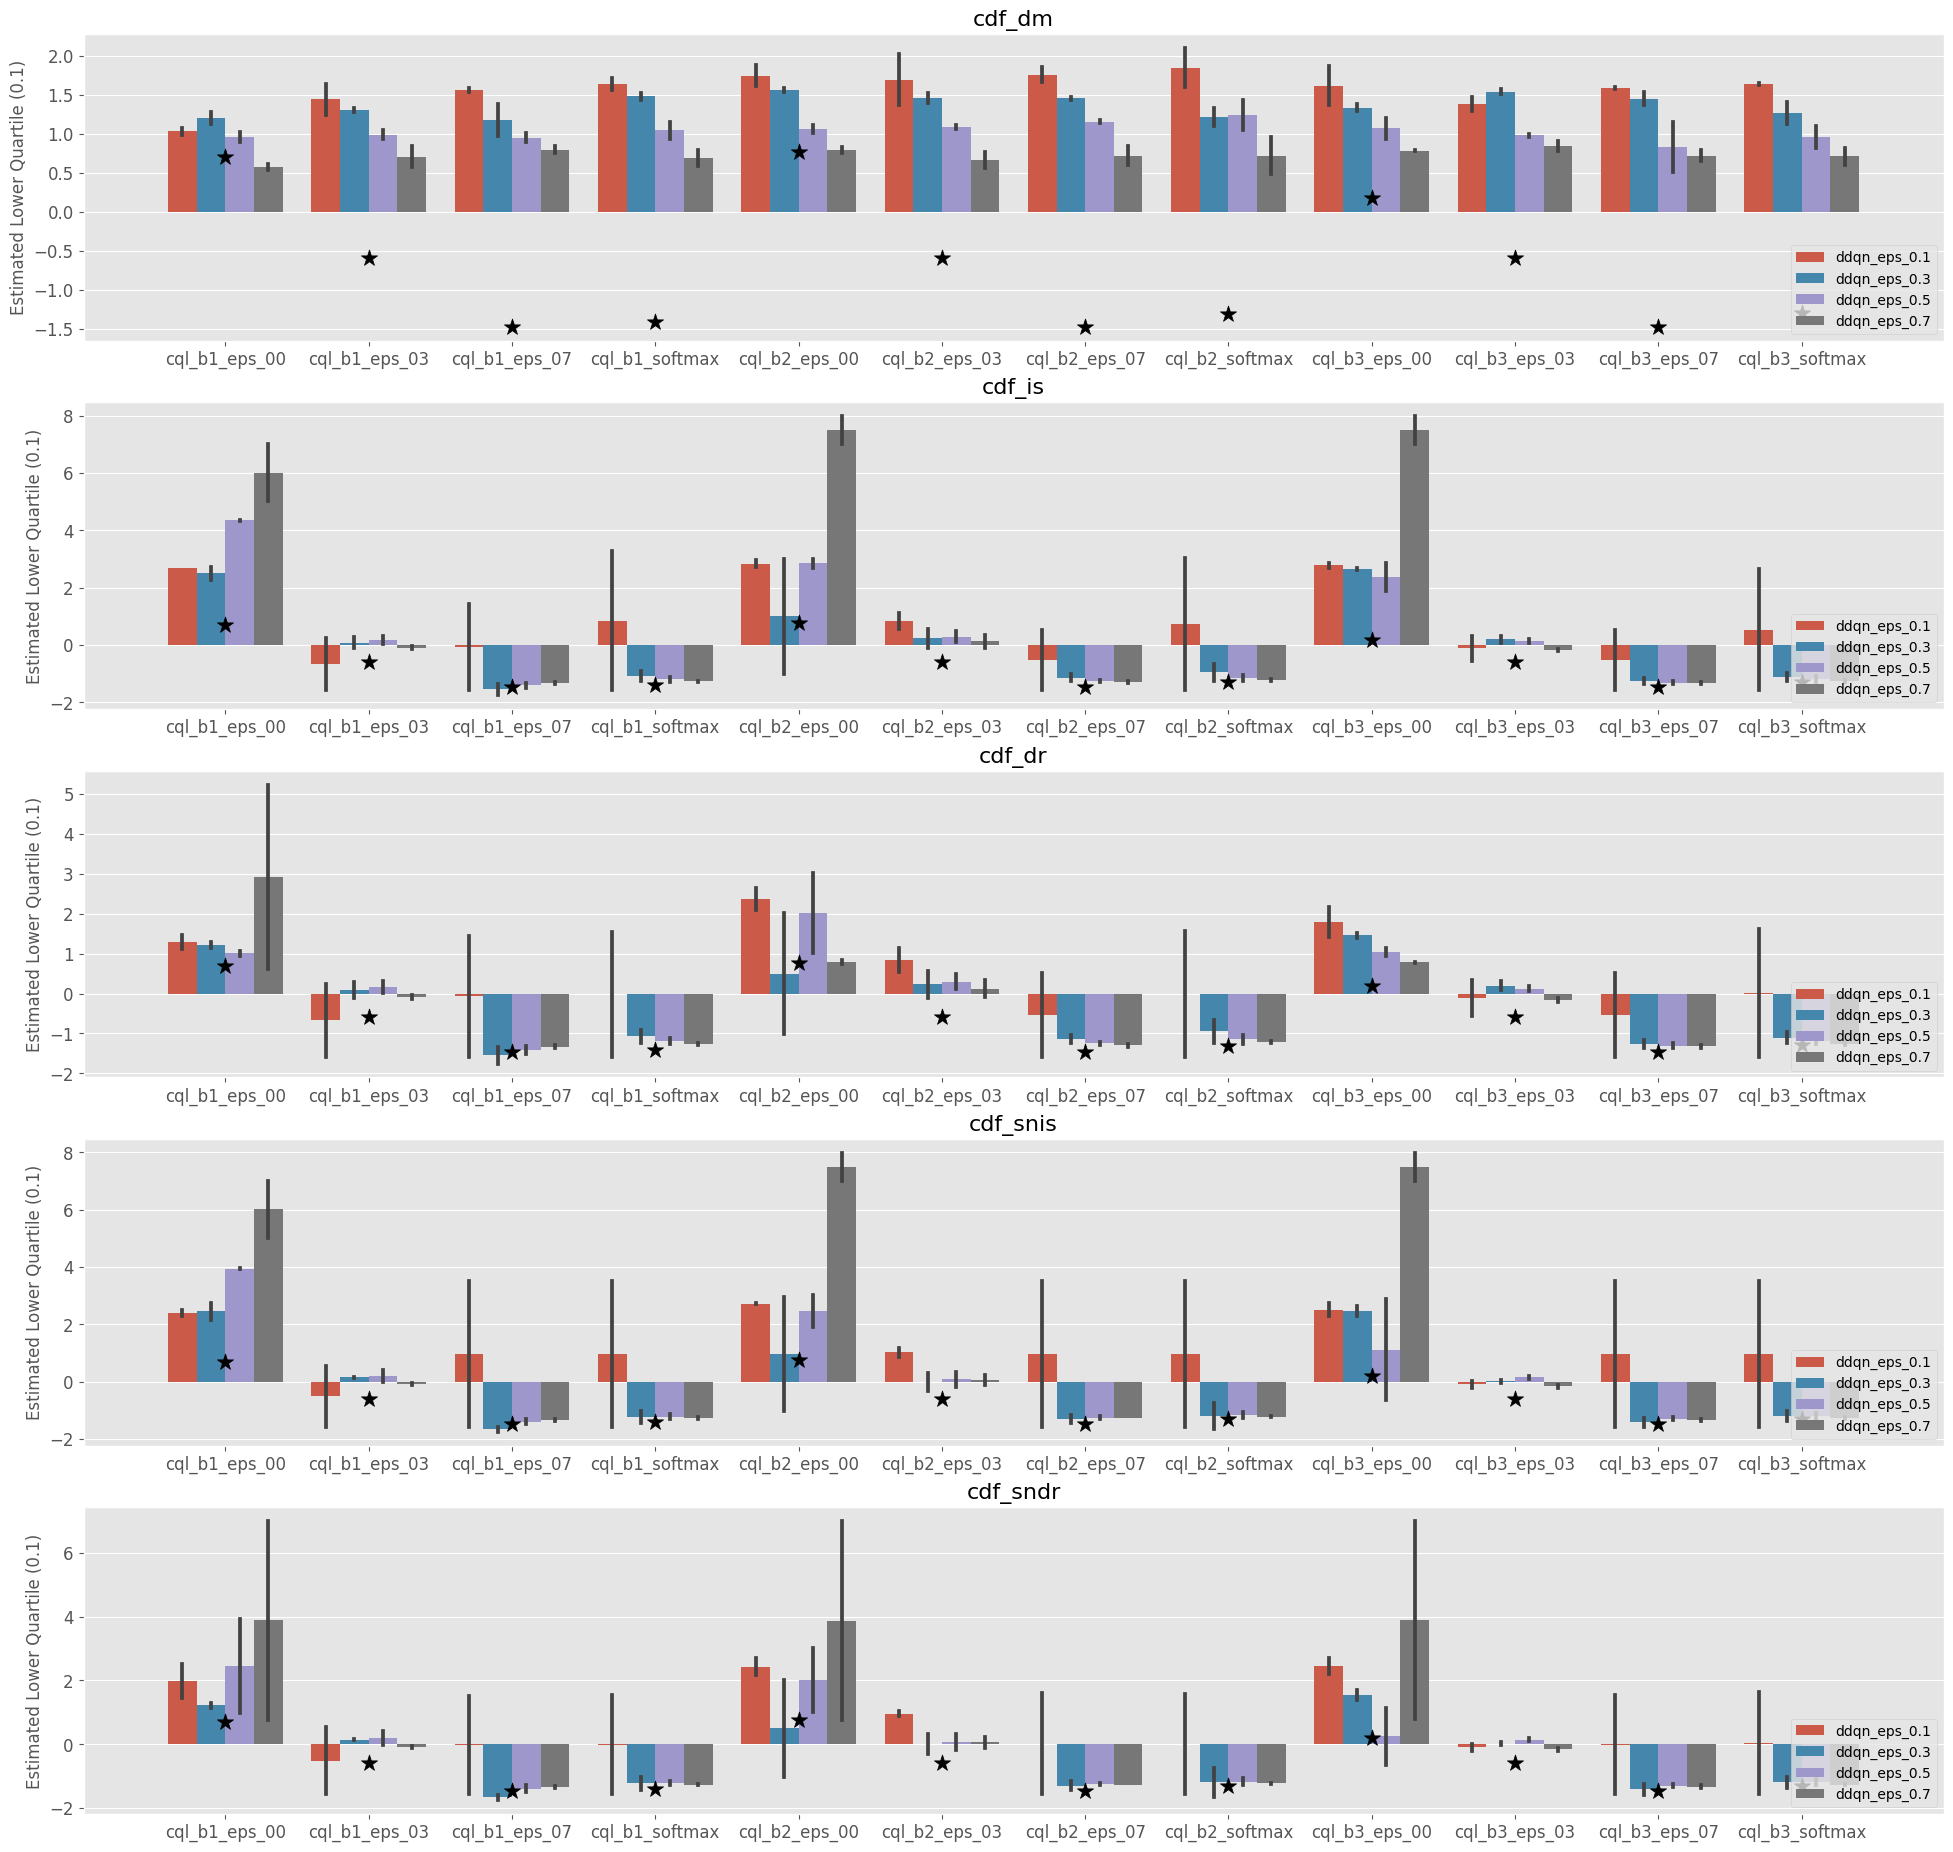

In [51]:
cd_ope.visualize_lower_quartile_with_multiple_estimates(
    input_dict=input_dict,
    alpha=0.1,
    plot_type="ci",
    hue="policy",
)

## 3. Off-Policy Selection

Off Policy Selection aims to select the ''best'' policy among several candidate policies based on some metrics.

In [52]:
from ofrl.ope import OffPolicySelection

In [53]:
ops = OffPolicySelection(
    ope=ope,
    cumulative_distribution_ope=cd_ope,
)

In [54]:
true_selection_result = ops.obtain_true_selection_result(
    input_dict=input_dict,
    return_variance=True,
    return_lower_quartile=True,
    return_conditional_value_at_risk=True,
    return_by_dataframe=True,
)
true_selection_result["ddqn_eps_0.1"][0]

ranking  policy_value  relative_policy_value  variance  \
0    cql_b1_eps_00      4.818452               1.354964  7.741324   
1    cql_b2_eps_00      4.781225               1.344496  7.973101   
2    cql_b3_eps_00      4.769551               1.341213  7.850306   
3    cql_b1_eps_03      3.105679               0.873327  6.173848   
4    cql_b2_eps_03      3.046595               0.856712  6.337791   
5    cql_b3_eps_03      2.983021               0.838835  6.099385   
6   cql_b2_softmax      1.127640               0.317096  2.614341   
7   cql_b1_softmax      1.035664               0.291232  2.797340   
8   cql_b3_softmax      0.959527               0.269822  2.682940   
9    cql_b1_eps_07      0.752302               0.211550  3.712670   
10   cql_b2_eps_07      0.688810               0.193696  3.848545   
11   cql_b3_eps_07      0.676212               0.190153  3.860547   

   ranking_by_lower_quartile  lower_quartile  \
0              cql_b1_eps_00       -0.543287   
1              cql_b1_eps_03       -0.640248   
2              cql_b1_eps_07       -0.667947   
3             cql_b1_softmax       -1.111411   
4              cql_b2_eps_00       -1.120541   
5              cql_b2_eps_03       -1.121599   
6              cql_b2_eps_07       -1.657181   
7             cql_b2_softmax       -1.658056   
8              cql_b3_eps_00       -1.695481   
9              cql_b3_eps_03       -1.768799   
10             cql_b3_eps_07       -1.923402   
11            cql_b3_softmax       -2.134090   

   ranking_by_conditional_value_at_risk  conditional_value_at_risk  
0                         cql_b3_eps_00                  -1.403815  
1                         cql_b1_eps_00                  -1.453062  
2                         cql_b2_eps_00                  -1.508286  
3                         cql_b2_eps_03                  -1.747093  
4                        cql_b3_softmax                  -1.817257  
5                        cql_b2_softmax                  -1.833597  
6                         cql_b3_eps_03                  -1.839867  
7                         cql_b1_eps_03                  -1.841071  
8                        cql_b1_softmax                  -2.034487  
9                         cql_b1_eps_07                  -2.516532  
10                        cql_b2_eps_07                  -2.632286  
11                        cql_b3_eps_07                  -2.633109

In [55]:
ranking_df, metric_df = ops.select_by_policy_value(
    input_dict=input_dict,
    return_true_values=True,
    return_metrics=True,
    return_by_dataframe=True,
)

In [56]:
ranking_df["ddqn_eps_0.1"][0]

{'dm':    estimated_ranking  estimated_policy_value  estimated_relative_policy_value  \
 0      cql_b2_eps_00                2.631714                         0.740046   
 1      cql_b2_eps_03                2.554081                         0.718216   
 2     cql_b2_softmax                2.212892                         0.622272   
 3      cql_b3_eps_00                2.097486                         0.589820   
 4      cql_b1_eps_03                2.094906                         0.589094   
 5      cql_b2_eps_07                2.019013                         0.567753   
 6      cql_b3_eps_07                1.883229                         0.529570   
 7     cql_b1_softmax                1.864919                         0.524421   
 8      cql_b1_eps_07                1.847696                         0.519578   
 9      cql_b3_eps_03                1.810674                         0.509167   
 10     cql_b1_eps_00                1.806845                         0.508091   
 11    cql

In [57]:
metric_df["ddqn_eps_0.1"][0]

estimator  mean_squared_error  rank_correlation    pvalue  regret@1  \
0        dm            2.530422          0.286713  0.366251  0.037227   
1       tis            1.656218          0.916084  0.000028  0.000000   
2      pdis            0.558329          0.916084  0.000028  0.000000   
3        dr            1.153006          0.846154  0.000521  0.037227   
4     sntis            0.903735          0.902098  0.000060  0.037227   
5    snpdis            0.086104          0.923077  0.000019  0.000000   
6      sndr            0.128124          0.895105  0.000084  0.000000   

   type_i_error_rate  type_ii_error_rate  
0           0.000000                 0.0  
1           0.333333                 0.0  
2           0.083333                 0.0  
3           0.083333                 0.0  
4           0.333333                 0.0  
5           0.000000                 0.0  
6           0.000000                 0.0

In [58]:
topk_metric_df = ops.obtain_topk_policy_value_selected_by_standard_ope(
    input_dict=input_dict,
    compared_estimators=["dm", "tis", "pdis", "dr"],
    return_safety_violation_rate=True,
    safety_threshold=55.0,
    return_by_dataframe=True,
)

In [59]:
topk_metric_df[:30]

estimator  topk      k-th      best     worst      mean       std  \
0         dm     0  3.863451  3.863451  3.863451  3.863451       NaN   
1         dm     1  4.111927  4.554990  3.420387  3.987689  0.802285   
2         dm     2  2.732362  4.574976  2.223793  3.569247  1.279255   
3         dm     3  1.637437  4.574976  1.133027  3.086294  1.705716   
4         dm     4  3.408070  4.792267  1.088095  3.150649  1.622351   
5         dm     5  1.550730  4.792267  0.980374  2.883996  1.662758   
6         dm     6  1.856856  4.796920  0.680937  2.737262  1.693591   
7         dm     7  1.926507  4.801573  0.679362  2.635917  1.705692   
8         dm     8  1.898200  4.803033  0.679362  2.553949  1.723575   
9         dm     9  2.147989  4.813799  0.677787  2.513353  1.743490   
10        dm    10  2.490786  4.818452  0.677787  2.511301  1.737167   
11        dm    11  1.120365  4.818452  0.676212  2.395390  1.720450   
0        tis     0  4.065335  4.065335  4.065335  4.065335       NaN   
1        tis     1  4.051545  4.079394  4.037486  4.058440  0.029634   
2        tis     2  4.066618  4.096087  4.034567  4.061166  0.031920   
3        tis     3  2.565734  4.143004  2.509305  3.687308  0.801126   
4        tis     4  2.539038  4.143004  2.465573  3.457654  0.874882   
5        tis     5  2.527407  4.143004  2.441733  3.302613  0.878950   
6        tis     6  1.265188  4.390259  0.961504  3.011552  1.291805   
7        tis     7  1.146274  4.390259  0.795122  2.778392  1.457403   
8        tis     8  1.396531  4.599702  0.751765  2.624852  1.567146   
9        tis     9  1.657525  4.807686  0.692022  2.528119  1.628878   
10       tis    10  1.735653  4.813799  0.679362  2.456077  1.692234   
11       tis    11  1.727831  4.818452  0.676212  2.395390  1.720450   
0       pdis     0  4.293305  4.293305  4.293305  4.293305       NaN   
1       pdis     1  4.268374  4.300877  4.260802  4.280839  0.028337   
2       pdis     2  4.276061  4.310183  4.257883  4.279247  0.027445   
3       pdis     3  2.851039  4.357101  2.794610  3.922195  0.767388   
4       pdis     4  2.745978  4.357101  2.710563  3.686951  0.859452   
5       pdis     5  3.254916  4.813799  2.694670  3.614945  1.039217   

    safety_violation_rate  sharpe_ratio  
0                     1.0           NaN  
1                     1.0    161.066130  
2                     1.0     17.061798  
3                     1.0      1.512346  
4                     1.0      1.663662  
5                     1.0      1.667248  
6                     1.0      1.609050  
7                     1.0      1.602408  
8                     1.0      1.572372  
9                     1.0      1.540843  
10                    1.0      1.550121  
11                    1.0      1.560549  
0                     1.0           NaN  
1                     1.0     50.284129  
2                     1.0     61.794128  
3                     1.0      1.170818  
4                     1.0      2.362915  
5                     1.0      2.340946  
6                     1.0      2.771759  
7                     1.0      2.450225  
8                     1.0      1.583754  
9                     1.0      1.647756  
10                    1.0      1.585511  
11                    1.0      1.560549  
0                     1.0           NaN  
1                     1.0     56.264191  
2                     1.0     71.727728  
3                     1.0      1.491645  
4                     1.0      2.603370  
5                     1.0      3.159347

In [69]:
ops.visualize_topk_policy_value_selected_by_standard_ope(
    input_dict=input_dict,
    compared_estimators=["dm", "tis", "pdis", "dr"],
    visualize_ci=True,
    safety_threshold=5.0,
    legend=True,
    random_state=random_state,
)

AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [ ]:
ops.visualize_topk_policy_value_selected_by_cumulative_distribution_ope(
    input_dict=input_dict,
    visualize_ci=True,
    safety_threshold=1.0,
    legend=True,
    random_state=random_state,
)

In [ ]:
ops.visualize_topk_policy_value_selected_by_lower_bound(
    input_dict=input_dict,
    compared_estimators=["dm", "tis", "pdis", "dr"],
    ope_cis=["bootstrap", "bernstein", "hoeffding", "ttest"],
    visualize_ci=True,
    safety_threshold=1.0,
    legend=True,
    random_state=random_state,
)

In [ ]:
ops.visualize_topk_conditional_value_at_risk_selected_by_standard_ope(
    input_dict=input_dict,
    compared_estimators=["dm", "tis", "pdis", "dr"],
    visualize_ci=True,
    ope_alpha=0.10,
    safety_threshold=8.0,
    legend=True,
    random_state=random_state,
)

In [ ]:
ops.visualize_topk_conditional_value_at_risk_selected_by_cumulative_distribution_ope(
    input_dict=input_dict,
    visualize_ci=True,
    ope_alpha=0.10,
    safety_threshold=8.0,
    legend=True,
    random_state=random_state,
)

In [ ]:
ops.visualize_topk_lower_quartile_selected_by_standard_ope(
    input_dict=input_dict,
    compared_estimators=["dm", "tis", "pdis", "dr"],
    visualize_ci=True,
    ope_alpha=0.10,
    safety_threshold=9.0,
    legend=True,
    random_state=random_state,
)

In [ ]:
ops.visualize_topk_lower_quartile_selected_by_cumulative_distribution_ope(
    input_dict=input_dict,
    visualize_ci=True,
    ope_alpha=0.10,
    safety_threshold=9.0,
    legend=True,
    random_state=random_state,
)

In [ ]:
ops.visualize_policy_value_for_validation(
    input_dict=input_dict,
    n_cols=4,
    share_axes=True,
)

In [ ]:
ops.visualize_policy_value_of_cumulative_distribution_ope_for_validation(
    input_dict=input_dict,
    share_axes=True,
)

In [ ]:
ops.visualize_variance_for_validation(
    input_dict=input_dict,
    share_axes=True,
)

In [ ]:
ops.visualize_lower_quartile_for_validation(
    input_dict=input_dict,
    share_axes=True,
)

In [ ]:
ops.visualize_conditional_value_at_risk_for_validation(
    input_dict=input_dict,
    share_axes=True,
)

<!-- For the examples in the continuous action space, please refer to [examples/quickstart/rec_synthetic_continuous_multiple_datasets.ipynb](https://github.com/negocia-inc/rec_reinforcement_learing/blob/ope/examples/quickstart/rec_synthetic_continuous_multiple_datasets.ipynb). -->

## Reference

- Vladislav Kurenkov and Sergey Kolesnikov. \
"Showing Your Offline Reinforcement Learning Work: Online Evaluation Budget Matters.", 2022.

- Audrey Huang, Liu Leqi, Zachary C. Lipton, and Kamyar Azizzadenesheli. \
"Off-Policy Risk Assessment for Markov Decision Processes.", 2022.

- Yuta Saito, Shunsuke Aihara, Megumi Matsutani, and Yusuke Narita. \
"Open Bandit Dataset and Pipeline: Towards Realistic and Reproducible Off-Policy Evaluation.", 2021.

- Takuma Seno and Michita Imai. \
"d3rlpy: An Offline Deep Reinforcement Library.", 2021.

- Shengpu Tang and Jenna Wiens. \
"Model Selection for Offline Reinforcement Learning: Practical Considerations for Healthcare Settings.", 2021.

- Justin Fu, Mohammad Norouzi, Ofir Nachum, George Tucker, Ziyu Wang, Alexander Novikov, Mengjiao Yang, Michael R. Zhang, Yutian Chen, Aviral Kumar, Cosmin Paduraru, Sergey Levine, and Tom Le Paine. \
"Benchmarks for Deep Off-Policy Evaluation.", 2021.

- Audrey Huang, Liu Leqi, Zachary C. Lipton, and Kamyar Azizzadenesheli. \
"Off-Policy Risk Assessment in Contextual Bandits.", 2021.

- Yash Chandak, Scott Niekum, Bruno Castro da Silva, Erik Learned-Miller, Emma Brunskill, and Philip S. Thomas. \
"Universal Off-Policy Evaluation.", 2021.

- Sergey Levine, Aviral Kumar, George Tucker, and Justin Fu. \
"Offline Reinforcement Learning: Tutorial, Review, and Perspectives on Open Problems." 2020.

- Tom Le Paine, Cosmin Paduraru, Andrea Michi, Caglar Gulcehre, Konrad Zolna, Alexander Novikov, Ziyu Wang, and Nando de Freitas. \
"Hyperparameter Selection for Offline Reinforcement Learning.", 2020.

- Aviral Kumar, Aurick Zhou, George Tucker, and Sergey Levine. \
"Conservative Q-Learning for Offline Reinforcement Learning.", 2020.

- Nathan Kallus and Masatoshi Uehara. \
"Intrinsically Efficient, Stable, and Bounded Off-Policy Evaluation for Reinforcement Learning.", 2019.

- Hoang Le, Cameron Voloshin, and Yisong Yue. \
"Batch Policy Learning under Constraints.", 2019.

- Di Wu, Xiujun Chen, Xun Yang, Hao Wang, Qing Tan, Xiaoxun Zhang, Jian Xu, and Kun Gai. \
"Budget Constrained Bidding by Model-free Reinforcement Learning in Display Advertising.", 2018.

- Jun Zhao, Guang Qiu, Ziyu Guan, Wei Zhao, and Xiaofei He. \
"Deep Reinforcement Learning for Sponsored Search Real-time Bidding.", 2018.

- Josiah P. Hanna, Peter Stone, and Scott Niekum. \
"Bootstrapping with Models: Confidence Intervals for Off-Policy Evaluation.", 2017.

- Nan Jiang and Lihong Li. \
"Doubly Robust Off-policy Value Evaluation for Reinforcement Learning.", 2016.

- Philip S. Thomas and Emma Brunskill. \
"Data-Efficient Off-Policy Policy Evaluation for Reinforcement Learning.", 2016.

- Greg Brockman, Vicki Cheung, Ludwig Pettersson, Jonas Schneider, John Schulman, Jie Tang, and Wojciech Zaremba. \
"OpenAI Gym.", 2016.

- Philip S. Thomas, Georgios Theocharous, and Mohammad Ghavamzadeh. \
"High Confidence Policy Improvement.", 2015.

- Philip S. Thomas, Georgios Theocharous, and Mohammad Ghavamzadeh. \
"High Confidence Off-Policy Evaluation.", 2015.

- Adith Swaminathan and Thorsten Joachims. \
"The Self-Normalized Estimator for Counterfactual Learning.", 2015.

- Hado van Hasselt, Arthur Guez, and David Silver. \
"Deep Reinforcement Learning with Double Q-learning.", 2015.

- Miroslav Dudík, Dumitru Erhan, John Langford, and Lihong Li. \
"Doubly Robust Policy Evaluation and Optimization.", 2014.

- Alex Strehl, John Langford, Sham Kakade, and Lihong Li. \
"Learning from Logged Implicit Exploration Data.", 2010.

- Alina Beygelzimer and John Langford. \
"The Offset Tree for Learning with Partial Labels.", 2009.

- Doina Precup, Richard S. Sutton, and Satinder P. Singh. \
"Eligibility Traces for Off-Policy Policy Evaluation.", 2000.